# Pips

In [170]:
# !pip install kaggle
# !pip install wordcloud
# !pip install gensim
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install nltk
# !pip install pyLDAvis
# !pip install xgboost
# !pip install lime

In [171]:
# # For SMOTE to work
# !pip install scikit-learn==1.4.2 imbalanced-learn==0.12.3 --force-reinstall
# # For latest sklearn version
# !pip install scikit-learn==1.7.0 --force-reinstall

# Libraries

In [1]:
## API
from kaggle.api.kaggle_api_extended import KaggleApi

## Core
import os
import pandas as pd
import numpy as np
import sys
import re
import time
import random
from datetime import datetime
import json
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
random.seed(42)
np.random.seed(42)

## Preprocessing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

## Embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize

## Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

## Supervised
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from xgboost import XGBClassifier
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Deep learning
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

## Unsupervised
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import Counter
from copy import deepcopy
import plotly.express as px
import plotly.graph_objects as go
from gensim.models import CoherenceModel

In [2]:
# Download required NLTK resources
nltk.download('wordnet')  # Download WordNet, a lexical database of English words
nltk.download('omw-1.4')  # WordNet Lemmas sometimes need this, which is a mapping of WordNet lemmas to their Part of Speech (POS) tags.
nltk.download('averaged_perceptron_tagger_eng')  # Download English POS tagger

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Paths

In [8]:
# ## Change with your path
path = 'C:/Users/Chris/Desktop/ML/NLP'
pathout = 'C:/Users/Chris/Desktop/ML/NLP'

## Change with your path
# path = 'c:\\Users\\it02\\Downloads'
# pathout = 'c:\\Users\\it02\\Downloads'

In [9]:
## Set HF home to your hugging face cache folder - no changes needed. This is used for transformers
HF_HOME = os.path.expanduser("~/.cache/huggingface")
## If you havent set your HF TOKEN as an environmental variable replace os.environ["HF_TOKEN"] below with your actual key
HF_TOKEN = os.environ["HF_TOKEN"]

# Kaggle API

In [10]:
## Run it once if you are using APIs and have set Kaggle username and Kaggle key as environmental variables
# api = KaggleApi()
# api.authenticate()
# api.dataset_download_files(dataset='shivamb/real-or-fake-fake-jobposting-prediction',path=path,unzip=True)

# File load

In [11]:
start_time = time.time()

In [12]:
## Regardless of running the previous cell you can load the file from here
df = pd.read_csv(path + '/fake_job_postings.csv')

## Duplicates, dimentionality, data types

In [13]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')
print(f'Dimentionality: {df.shape}')
print(f'Data types: {df.dtypes}')

Number of duplicated rows: 0
Dimentionality: (17880, 18)
Data types: job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object


## Target variable value counts & plot

In [14]:
y = df['fraudulent']
y.value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

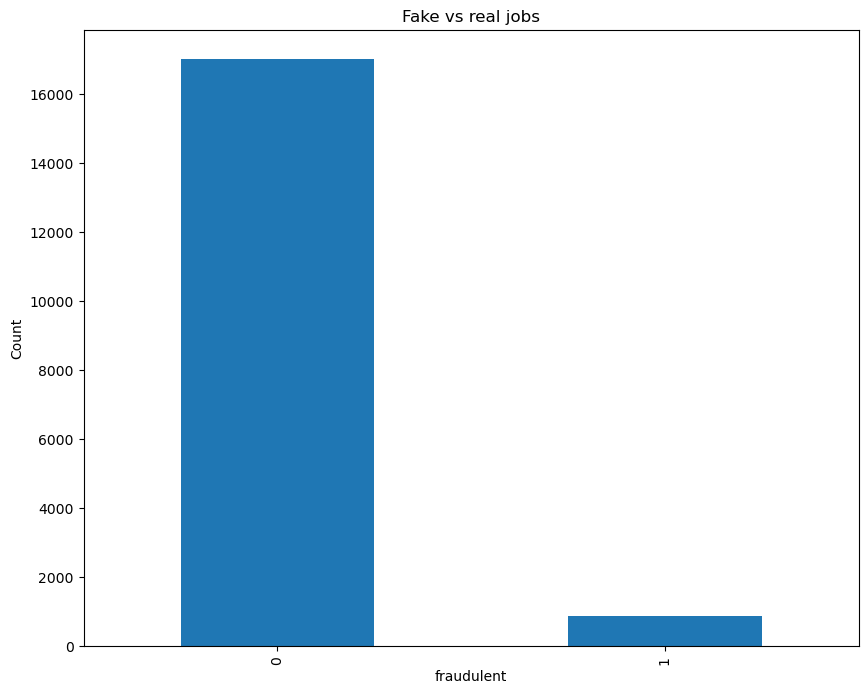

In [15]:
fraudulent = y.value_counts()
plt.figure(figsize=(10, 8))
fraudulent.plot(kind='bar')
plt.title('Fake vs real jobs')
plt.xlabel('fraudulent')
plt.ylabel('Count')
plt.show()

In [16]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

## Handling nulls

In [17]:
# Drop row with missing description
df = df[df['description'].notnull()]
# Reset y to match dimentions
y = df['fraudulent']

# Fill text-heavy optional fields with empty strings. Models can’t process nulls — they’ll throw errors. Empty space is not null
df['company_profile'] = df['company_profile'].fillna('No company profile provided')
df['requirements'] = df['requirements'].fillna('Requirements not specified')
df['benefits'] = df['benefits'].fillna('Benefits not mentioned')

# Fill categorical fields with column-specific placeholders
df['salary_range'] = df['salary_range'].fillna('Not disclosed') # We can drop this - too many nulls
df['department'] = df['department'].fillna('Department Unknown') # We can drop this - too many nulls
df['location'] = df['location'].fillna('Location Unknown')
df['employment_type'] = df['employment_type'].fillna('Employment Unknown')
df['required_experience'] = df['required_experience'].fillna('Experience Unknown')
df['required_education'] = df['required_education'].fillna('Education Unknown')
df['industry'] = df['industry'].fillna('Industry Unknown')
df['function'] = df['function'].fillna('Function Unknown')
df['title'] = df['title'].fillna('Title Unknown')

# Optional: Add missingness indicators for modeling. This is useful for supervised, not so much for unsupervised
# df['has_salary_info'] = df['salary_range'].notnull().astype(int)
# df.drop('salary_range', axis=1, inplace=True)
# df['missing_company_profile'] = (df['company_profile'] == '').astype(int)
# df['missing_requirements'] = (df['requirements'] == '').astype(int)
# df['missing_benefits'] = (df['benefits'] == '').astype(int)
# df['missing_department'] = (df['department'] == 'Department Unknown').astype(int)
# df['missing_employment_type'] = (df['employment_type'] == 'Employment Unknown').astype(int)

In [18]:
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

# Preprocessing

### Missing spaces

In [19]:
text_columns = ['title', 'location', 'department', 'salary_range', 'company_profile',
                        'description', 'requirements', 'benefits', 'function', 'industry',
                        'employment_type', 'required_experience', 'required_education']

In [20]:
def fix_missing_spaces(text):
    text = str(text)
    # Fix things like "cards.Gabriel" → "cards. Gabriel"
    text = re.sub(r'([.,;!?])(?=\w)', r'\1 ', text)
    # Fix CamelCase: "teamProfessional" → "team Professional"
    text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)
    # Clean up extra spaces just in case
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [21]:
for col in text_columns:
    df[col] = df[col].map(fix_missing_spaces)

### Lowercase

In [22]:
def lowercase_text(text):
    # Convert text to lowercase.
    return str(text).lower()

In [23]:
for col in text_columns:
    df[col] = df[col].map(lowercase_text)

### Remove URLs

In [24]:
# Define the URL pattern
url_pattern = r"(?:https?|ftp)://[^\s/$.?#].[^\s]*"

# Dictionary to store counts
url_counts = {}

# Loop through all columns
for column in df.columns:
    if df[column].dtype == "object":  # Check only text columns
        url_count = df[column].dropna().apply(lambda x: len(re.findall(url_pattern, x)) if isinstance(x, str) else 0).sum()
        url_counts[column] = url_count

# Print results
for col, count in sorted(url_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count} URLs found in text columns")

company_profile: 139 URLs found in text columns
description: 60 URLs found in text columns
benefits: 10 URLs found in text columns
requirements: 1 URLs found in text columns
title: 0 URLs found in text columns
location: 0 URLs found in text columns
department: 0 URLs found in text columns
salary_range: 0 URLs found in text columns
employment_type: 0 URLs found in text columns
required_experience: 0 URLs found in text columns
required_education: 0 URLs found in text columns
industry: 0 URLs found in text columns
function: 0 URLs found in text columns


In [25]:
def replace_urls(text):
    """
    Replace URLs in the text with the token 'URL'.
    Prints before and after if a replacement occurs.
    """
    text_str = str(text)
    replaced_text = re.sub(url_pattern, 'URL', text_str)

    # if replaced_text != text_str:
    #     print(f"Before: {text_str}")
    #     print(f"After:  {replaced_text}\n")

    return replaced_text

In [26]:
for col in text_columns:
    df[col] = df[col].map(replace_urls)

### Remove extra letters from URLs

In [27]:
# Pattern to replace any token that starts with 'url' by just 'url'
url_cleanup_pattern = r'\burl\w*\b'

def reduce_to_url_only(text):
    """
    Replaces any word that starts with 'url' with just 'url'.
    """
    text_str = str(text)
    cleaned = re.sub(url_cleanup_pattern, 'url', text_str)
    return re.sub(r'\s+', ' ', cleaned).strip()

In [28]:
for col in text_columns:
    df[col] = df[col].map(reduce_to_url_only)

### Remove emojis & emoticons

In [29]:
emoji_pattern = re.compile("["
    # Emoticons (e.g., 😀😁😂🤣😃😄😅😆)
    u"\U0001F600-\U0001F64F"
    # Symbols & pictographs (e.g., 🔥🎉💡📦📱)
    u"\U0001F300-\U0001F5FF"
    # Transport & map symbols (e.g., 🚗✈️🚀🚉)
    u"\U0001F680-\U0001F6FF"
    # Flags (e.g., 🇺🇸🇬🇧🇨🇦 — these are pairs of regional indicators)
    u"\U0001F1E0-\U0001F1FF"
    # Dingbats (e.g., ✂️✈️✉️⚽)
    u"\u2700-\u27BF"
    # Supplemental Symbols & Pictographs (e.g., 🤖🥰🧠🦾)
    u"\U0001F900-\U0001F9FF"
    # Symbols & Pictographs Extended-A (e.g., 🪄🪅🪨)
    u"\U0001FA70-\U0001FAFF"
    # Miscellaneous symbols (e.g., ☀️☁️☂️⚡)
    u"\u2600-\u26FF"
    "]+", flags=re.UNICODE)

In [30]:
emoji_counts = {}
for column in df.columns:
    if df[column].dtype == "object":
        count = df[column].dropna().apply(
            lambda x: len(emoji_pattern.findall(x)) if isinstance(x, str) else 0
        ).sum()
        emoji_counts[column] = count

for col, count in sorted(emoji_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count} emojis found")

description: 10 emojis found
requirements: 5 emojis found
benefits: 5 emojis found
title: 0 emojis found
location: 0 emojis found
department: 0 emojis found
salary_range: 0 emojis found
company_profile: 0 emojis found
employment_type: 0 emojis found
required_experience: 0 emojis found
required_education: 0 emojis found
industry: 0 emojis found
function: 0 emojis found


In [31]:
# Define the emoticon pattern
emoticon_pattern = re.compile(r'(:\)|:\(|:D|:P|;\)|:-\)|:-D|:-P|:\'\(|:\||:\*)')

# Dictionary to store emoticon counts
emoticon_count = {}

# Loop through all text columns
for column in df.columns:
    if df[column].dtype == "object":
        count = df[column].dropna().apply(
            lambda x: len(emoticon_pattern.findall(x)) if isinstance(x, str) else 0
        ).sum()
        emoticon_count[column] = count

# Print results
for col, count in sorted(emoticon_count.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count} Emoticons found in text")

company_profile: 843 Emoticons found in text
description: 524 Emoticons found in text
requirements: 129 Emoticons found in text
benefits: 127 Emoticons found in text
title: 0 Emoticons found in text
location: 0 Emoticons found in text
department: 0 Emoticons found in text
salary_range: 0 Emoticons found in text
employment_type: 0 Emoticons found in text
required_experience: 0 Emoticons found in text
required_education: 0 Emoticons found in text
industry: 0 Emoticons found in text
function: 0 Emoticons found in text


In [32]:
def remove_and_print(text):
    if emoji_pattern.search(text) or emoticon_pattern.search(text):
        # print(f"Before: {text}")
        text = emoji_pattern.sub('', text)
        text = emoticon_pattern.sub('', text)
        # print(f"After: {text}")
        # print()
    return text

In [33]:
for col in text_columns:
    df[col] = df[col].map(remove_and_print)

### Replacing Usernames

In [34]:
username_email_counts = {}

# Patterns to match
email_pattern = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
username_pattern = re.compile(r'(?:(?<=^)|(?<=[\s.,;!?]))@\w+\b')

for column in df.columns:
    if df[column].dtype == "object":
        count = df[column].dropna().apply(
            lambda x: (
                len(email_pattern.findall(x)) +
                len(username_pattern.findall(x))
            ) if isinstance(x, str) else 0
        ).sum()
        username_email_counts[column] = count

# Print counts
for col, count in sorted(username_email_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{col}: {count} usernames/emails found")

benefits: 54 usernames/emails found
title: 22 usernames/emails found
company_profile: 17 usernames/emails found
description: 10 usernames/emails found
requirements: 6 usernames/emails found
location: 0 usernames/emails found
department: 0 usernames/emails found
salary_range: 0 usernames/emails found
employment_type: 0 usernames/emails found
required_experience: 0 usernames/emails found
required_education: 0 usernames/emails found
industry: 0 usernames/emails found
function: 0 usernames/emails found


In [35]:
def replace_usernames(text):
    original = str(text)
    updated = original
    # Replace full email addresses
    updated = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', 'USER', updated)
    # Replace @usernames only when preceded by space, punctuation, or start of string
    updated = re.sub(r'(?:(?<=^)|(?<=[\s.,;!?]))@\w+\b', 'USER', updated)
    # if updated != original:
    #     print(f"Before: {original}")
    #     print(f"After:  {updated}\n")
    return updated

In [36]:
for col in text_columns:
    df[col] = df[col].apply(replace_usernames)

### Removing Non-Alphabets

In [37]:
def clean_text(text, keep_punct=False):
    # Convert input to string (safe handling)
    original = str(text)

    if keep_punct:
        # Keep only lowercase letters, spaces, and select punctuation (. ! ?)
        # Useful for capturing tone/sentiment
        cleaned = re.sub(r"[^a-z\s.!?]", "", original)
    else:
        # Keep only lowercase letters and spaces; remove all punctuation and symbols
        cleaned = re.sub(r"[^a-z\s]", "", original)

    # Normalize whitespace (collapse multiple spaces to one, strip leading/trailing)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    # Optional: print before and after if a change occurred
    # if original != cleaned:
    #     print(f"Before: {text}")
    #     print(f"After:  {cleaned}\n")

    return cleaned

In [38]:
for col in text_columns:
    df[col] = df[col].map(clean_text)

### Removing Consecutive letters

In [39]:
def remove_consecutive_letters(text, max_repeat=2):
    text_str = str(text)
    pattern = r'(\w)\1{' + str(max_repeat) + r',}'
    cleaned = re.sub(pattern, r'\1' * max_repeat, text_str)
    # Print only if changes were made
    # if cleaned != text_str:
    #     print(f"Before: {text_str}")
    #     print(f"After:  {cleaned}\n")
    return cleaned

In [40]:
for col in text_columns:
    df[col] = df[col].apply(lambda x: remove_consecutive_letters(x, max_repeat=2))

### Removing Short Words

In [41]:
def remove_short_words(text, min_length=3, preserve_words=None):
    preserve = set(preserve_words or [])
    words = str(text).split()
    filtered = [word for word in words if len(word) >= min_length or word.lower() in preserve]
    result = ' '.join(filtered)
    # if result != text:
    #     print(f"Before: {text}")
    #     print(f"After:  {result}\n")
    return result

In [42]:
for col in text_columns:
    df[col] = df[col].apply(lambda x: remove_short_words(x, min_length=3, preserve_words={'no', 'not'}))

### Removing Stopwords

In [43]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Sample stopwords:", list(stopwords.words('english'))[:10])

Sample stopwords: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [44]:
base_stopwords = set(stopwords.words('english'))
preserve = {'no', 'not', 'nor', 'never'}
custom_stopwords = base_stopwords - preserve

In [45]:
def remove_stopwords(text):
    words = str(text).split()
    filtered = [word for word in words if word not in custom_stopwords]
    result = ' '.join(filtered)
    # if result != text:
    #     print(f"Before: {text}")
    #     print(f"After:  {result}\n")
    return result

In [46]:
for col in text_columns:
    df[col] = df[col].apply(remove_stopwords)

### Lemmatization

In [47]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [48]:
# POS mapping function
# POS tags can be: ADJ (adjective), ADV (adverb), NOUN (noun), VERB (verb), etc
def get_wordnet_pos(tag):
    # Determine the WordNet POS tag based on the first letter of the input tag
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to Noun if no match


def lemmatize_text(text):
    """
    Lemmatize text using WordNet lemmatizer with POS tagging.

    This version prints each change along with the POS tag of the changed word.
    """
    # Convert the input text to a string to ensure compatibility
    original_text = str(text)
    # Split the text into individual words
    words = original_text.split()
    # Obtain Part of Speech (POS) tags for each word
    pos_tags = pos_tag(words)

    # Initialize lists to store lemmatized words and any changes
    lemmatized_words = []
    changes = []

    # Iterate over each word and its POS tag
    for word, tag in pos_tags:
        # Map the POS tag to a WordNet POS tag
        wn_tag = get_wordnet_pos(tag)
        # Lemmatize the word using the mapped POS tag
        lemma = lemmatizer.lemmatize(word, wn_tag)

        # Check if the lemmatized word is different from the original
        if lemma != word:
            # Record the change if a difference is found
            changes.append((word, lemma, tag))
        # Add the lemmatized word to the list
        lemmatized_words.append(lemma)

    # Join the lemmatized words back into a single string
    result = ' '.join(lemmatized_words)

    # Print only if there were changes
    if changes:
        pass
        # print(f"\nOriginal: {original_text}")
        # print(f"Lemmatized: {result}")
        # for original, lemma, pos in changes:
        #     print(f"  - {original} → {lemma}  (POS: {pos})")
    return result

In [49]:
for col in text_columns:
    df[col] = df[col].apply(lemmatize_text)

# Save output to csv

In [50]:
df.head()

job_id                                    title    location  \
0       1                         marketing intern    new york   
1       2  customer service cloud video production    auckland   
2       3       commission machinery assistant cma       wever   
3       4             account executive washington  washington   
4       5                      bill review manager  fort worth   

           department  salary_range  \
0           marketing  not disclose   
1             success  not disclose   
2  department unknown  not disclose   
3                sale  not disclose   
4  department unknown  not disclose   

                                     company_profile  \
0  food weve create groundbreaking awardwinning c...   
1  second world cloud video production service se...   
2  valor service provide workforce solution meet ...   
3  passion improve quality life geography heart e...   
4  spot source solution llc global human capital ...   

                                         description  \
0  food fastgrowing james beard awardwinning onli...   
1  organise focused vibrant awesome passion custo...   
2  client locate houston actively seek experience...   
3  company esri environmental system research ins...   
4  job title itemization review manager location ...   

                                        requirements  \
0  experience content management system major plu...   
1  expect youyour key responsibility communicate ...   
2  implement precommissioning commission procedur...   
3  education bachelor master gi business administ...   
4  qualificationsrn license state texas diploma b...   

                                            benefits  telecommuting  \
0                                benefit not mention              0   
1  get part second team gainexperience work proje...              0   
2                                benefit not mention              0   
3  culture anything corporatewe collaborative cre...              0   
4                                 full benefit offer              0   

   has_company_logo  has_questions     employment_type required_experience  \
0                 1              0                              internship   
1                 1              0            fulltime      not applicable   
2                 1              0  employment unknown  experience unknown   
3                 1              0            fulltime     midsenior level   
4                 1              1            fulltime     midsenior level   

  required_education               industry              function  fraudulent  
0  education unknown       industry unknown             marketing           0  
1  education unknown  marketing advertising      customer service           0  
2  education unknown       industry unknown      function unknown           0  
3    bachelor degree      computer software                  sale           0  
4    bachelor degree   hospital health care  health care provider           0

In [51]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nExecution time: {elapsed_time:.2f} seconds")


Execution time: 196.70 seconds


In [52]:
df.to_csv(pathout + '/preprocessed_fake_job_postings.csv', index=False)

# Wordclouds

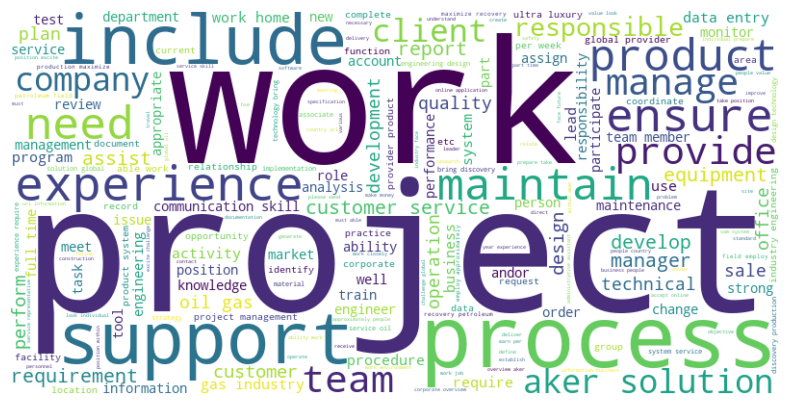

In [53]:
# Filter fraudulent job postings
filtered_postings = df[df['fraudulent'] == 1]

# Combine all descriptions (or use 'summary' if that’s what you meant)
all_postings = " ".join(str(desc) for desc in filtered_postings['description'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_postings)

# Clear the memory (not strictly necessary here)
all_postings = None

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

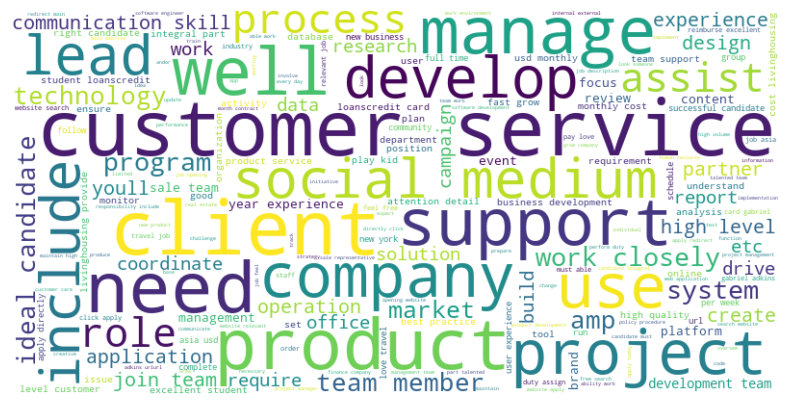

In [54]:
# Filter fraudulent job postings
filtered_postings = df[df['fraudulent'] == 0]

# Combine all descriptions (or use 'summary' if that’s what you meant)
all_postings = " ".join(str(desc) for desc in filtered_postings['description'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_postings)

# Clear the memory (not strictly necessary here)
all_postings = None

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Embeddings & Modeling

### TFIDF for most important terms

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df['description'], y, test_size=0.2, random_state=42)

In [56]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=384,  # Limit features to reduce dimensionality
    min_df=5,           # Minimum document frequency
    max_df=0.8,         # Maximum document frequency (ignore terms that appear in >80% of documents)
)

X_train = tfidf_vectorizer.fit_transform(X_train)

In [57]:
X_train[:5].toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.15655502],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.19129612, 0.09860584, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [58]:
np.mean(X_train.toarray())

0.013926076582901119

In [59]:
# Get the number of rows in X_train
num_rows = X_train.shape[0]

# Generate 10 random indices
random_indices = random.sample(range(num_rows), 10)

# Print 10 random lines of X_train
for idx in random_indices:
    print(f"Index: {idx}, Mean: {np.mean(X_train[idx].toarray()[0], axis=0)}")

Index: 10476, Mean: 0.010840864600022856
Index: 1824, Mean: 0.01727872146345143
Index: 409, Mean: 0.009534712212003896
Index: 12149, Mean: 0.009033368632538277
Index: 4506, Mean: 0.011957768256029492
Index: 4012, Mean: 0.015141177936840569
Index: 3657, Mean: 0.018538583565733846
Index: 2286, Mean: 0.012296354030879558
Index: 12066, Mean: 0.009968424591410582
Index: 1679, Mean: 0.012859825024527883


In [60]:
X_test = tfidf_vectorizer.transform(X_test)

In [61]:
print(f"Training TF-IDF matrix shape: {X_train.shape}")
print(f"Testing TF-IDF matrix shape: {X_test.shape}")

Training TF-IDF matrix shape: (14303, 384)
Testing TF-IDF matrix shape: (3576, 384)


In [62]:
# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features (words): {len(feature_names)}")
print(f"Features: {feature_names}")

Number of features (words): 384
Features: ['ability' 'able' 'account' 'achieve' 'across' 'activity' 'agency' 'also'
 'amp' 'analysis' 'analyze' 'andor' 'application' 'apply' 'appropriate'
 'area' 'around' 'assign' 'assist' 'associate' 'available' 'back' 'base'
 'benefit' 'best' 'big' 'brand' 'bring' 'budget' 'build' 'building'
 'business' 'call' 'campaign' 'candidate' 'card' 'care' 'career' 'center'
 'challenge' 'change' 'client' 'close' 'closely' 'code' 'come'
 'communicate' 'communication' 'community' 'company' 'competitive'
 'complete' 'complex' 'compliance' 'computer' 'conduct' 'consumer'
 'contact' 'content' 'contract' 'contribute' 'control' 'coordinate' 'cost'
 'create' 'creative' 'culture' 'current' 'currently' 'customer' 'daily'
 'data' 'database' 'day' 'decision' 'define' 'degree' 'deliver' 'delivery'
 'demonstrate' 'department' 'design' 'designer' 'detail' 'develop'
 'developer' 'development' 'digital' 'direct' 'direction' 'directly'
 'director' 'document' 'documentation' 'dr

In [63]:
# Get the sum of TF-IDF values for each term across all documents
tfidf_means = np.array(X_train.mean(axis=0)).flatten()

# Create a DataFrame with terms and their TF-IDF sums
term_importance = pd.DataFrame({
    'term': feature_names,
    'tfidf_mean': tfidf_means
})

# Sort by importance (TF-IDF sum)
term_importance = term_importance.sort_values('tfidf_mean', ascending=False)

# Display the top 10 most important terms
print("Top 10 most important terms:")
print(term_importance.head(10))

Top 10 most important terms:
           term  tfidf_mean
377        work    0.060925
348        team    0.056252
69     customer    0.052787
121  experience    0.045982
316     service    0.045012
270     product    0.042993
41       client    0.041731
306        sale    0.040924
31     business    0.040036
49      company    0.039902


### Skipgram Word2Vec for finding similar words

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df['description'], y, test_size=0.2, random_state=42)

In [65]:
tokenized_train = [text.split() for text in X_train]
tokenized_test = [text.split() for text in X_test]

In [66]:
tokenized_train[:10]

[['transfer',
  'cofounded',
  'skypes',
  'first',
  'employee',
  'back',
  'planet',
  'experience',
  'innovator',
  'include',
  'pay',
  'pal',
  'founder',
  'amp',
  'facebooks',
  'first',
  'investor',
  'peter',
  'thiel',
  'disrupt',
  'world',
  'currency',
  'amp',
  'international',
  'money',
  'transfer',
  'mean',
  'flipping',
  'gazillion',
  'dollar',
  'industry',
  'head',
  'take',
  'power',
  'away',
  'bank',
  'establishment',
  'locate',
  'one',
  'tallinn',
  'startup',
  'design',
  'hubs',
  'grow',
  'extraordinary',
  'rate',
  'look',
  'exceptional',
  'talent',
  'jump',
  'board',
  'currently',
  'people',
  'strong',
  'handle',
  'million',
  'customer',
  'money',
  'every',
  'day',
  'transfer',
  'wise',
  'boredomfree',
  'zone',
  'youre',
  'look',
  'stuffy',
  'financial',
  'company',
  'back',
  'button',
  'beckons',
  'want',
  'part',
  'something',
  'innovative',
  'truly',
  'excite',
  'read',
  'fastgrowing',
  'operation',


In [67]:
# Define the Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=384, # Dimensionality of the word vectors
    window=5, # Maximum distance between the current and predicted word within a sentence
    min_count=2, # Ignores words with frequency lower than this
    workers=4, # Number of threads to run in parallel
    sg=1, # Training algorithm: 1 for skip-gram; 0 for CBOW
    seed=42
)
print("Training Word2Vec model...")
# Train the model
w2v_model.train(
    tokenized_train, # List of sentences to train
    total_examples=len(tokenized_train), # Number of sentences to train on
    epochs=10 # Number of epochs
)

Training Word2Vec model...


(14644944, 15785870)

In [68]:
print(f"Vocabulary size: {len(w2v_model.wv.key_to_index)}")

Vocabulary size: 20113


In [69]:
# Function to create document vectors by averaging word vectors
def document_vector(doc, model):
    # Filter words that are in the model vocabulary
    doc_words = [word for word in doc if word in model.wv]
    if len(doc_words) == 0:
        # Return zeros if no words are in vocabulary
        return np.zeros(model.vector_size)
    # Return the mean of all word vectors in the document
    return np.mean([model.wv[word] for word in doc_words], axis=0)

In [70]:
# Create document vectors for training and testing sets
X_train = np.array([document_vector(doc, w2v_model) for doc in tokenized_train])
X_test = np.array([document_vector(doc, w2v_model) for doc in tokenized_test])

In [71]:
print(f"Training Word2Vec matrix shape: {X_train.shape}")
print(f"Testing Word2Vec matrix shape: {X_test.shape}")

Training Word2Vec matrix shape: (14303, 384)
Testing Word2Vec matrix shape: (3576, 384)


In [72]:
# Explore some word similarities
my_test_word = "developer"
try:
    # Find words most similar
    print(f"\nWords most similar to '{my_test_word}':")
    for word, similarity in w2v_model.wv.most_similar(my_test_word, topn=5):
        print(f"{word}: {similarity:.4f}")
except KeyError:
    print(f"Word '{my_test_word}' not in vocabulary. Try another common word.")


Words most similar to 'developer':
developerarchitect: 0.5316
webdesigner: 0.5103
developerprogrammer: 0.4978
developeras: 0.4889
curalate: 0.4850


# Supervised

### Embeddings for supervised

In [73]:
if torch.cuda.device_count()>0:
    my_device = "cuda"
    print(f"You have {torch.cuda.device_count()} GPUs available.")
else:
    my_device = "cpu"
    print("You have no GPUs available. Running on CPU.")

You have 1 GPUs available.


In [74]:
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2',
                                       token=HF_TOKEN,
                                       cache_folder=HF_HOME,
                                       device=my_device)

In [75]:
df = df.reset_index(drop=True)

df_description = df['description']
y = df['fraudulent']

In [76]:
# Encode the corpus using the embeddings model
word_embeddings_transformer = embeddings_model.encode(df_description)
# Print the shape of the resulting embeddings
print(word_embeddings_transformer.shape)
# Output the embeddings
word_embeddings_transformer

(17879, 384)


array([[-0.03726263, -0.05698282,  0.04677539, ..., -0.08999476,
         0.0256225 , -0.01009416],
       [ 0.01647796, -0.14246431,  0.00042718, ..., -0.08301047,
        -0.03339187, -0.01878843],
       [-0.02616427, -0.00709696,  0.01539601, ...,  0.06117666,
         0.03091396, -0.0013996 ],
       ...,
       [-0.02401464, -0.01162501,  0.01294735, ...,  0.04775572,
        -0.00737008,  0.01791953],
       [ 0.01176068,  0.01683556, -0.01543109, ..., -0.03729423,
        -0.05270043,  0.05560551],
       [-0.02039192, -0.06308167,  0.0063902 , ..., -0.06692131,
         0.01392854,  0.00449045]], dtype=float32)

### Train test split

In [77]:
# stratification bc dataset is imbalanced
X_train, X_test, y_train, y_test = train_test_split(word_embeddings_transformer, y, test_size=0.2, stratify=y, random_state=42) 

print(f"Training Transformers matrix shape: {X_train.shape}")
print(f"Testing Transformers matrix shape: {X_test.shape}")

Training Transformers matrix shape: (14303, 384)
Testing Transformers matrix shape: (3576, 384)


### Dataframe for storing results

In [78]:
# empty df to store models' results

clf_results = pd.DataFrame([])

### Support Vector Machine (SVM) - Benchmark model

In [79]:
rbf_svm = SVC()
rbf_svm.fit(X_train, y_train)
y_pred_rbf_svm = rbf_svm.predict(X_test)

print('Accuracy for RBF SVM is:', round(metrics.accuracy_score(y_test, y_pred_rbf_svm), 3))
print('\n', metrics.classification_report(y_test, y_pred_rbf_svm))

Accuracy for RBF SVM is: 0.968

               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3403
           1       1.00      0.35      0.52       173

    accuracy                           0.97      3576
   macro avg       0.98      0.67      0.75      3576
weighted avg       0.97      0.97      0.96      3576



In [80]:
# add the results to empty df

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'SVM Benchmark', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_rbf_svm), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_rbf_svm), 3)})])

clf_results

Model  Accuracy     F1
0  SVM Benchmark     0.968  0.515

### Random Forest

In [81]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Accuracy for Random Forest is ', round(metrics.accuracy_score(y_test, y_pred_rf), 3))
print('\n', metrics.classification_report(y_test, y_pred_rf))

Accuracy for Random Forest is  0.973

               precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       1.00      0.44      0.61       173

    accuracy                           0.97      3576
   macro avg       0.99      0.72      0.80      3576
weighted avg       0.97      0.97      0.97      3576



In [82]:
# add the results to df

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'RF', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_rf), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_rf), 3)})])

clf_results

Model  Accuracy     F1
0  SVM Benchmark     0.968  0.515
0             RF     0.973  0.610

### XGBoost

In [83]:

xgb_model = XGBClassifier(eval_metric='mlogloss')
sample_weights = compute_sample_weight("balanced", y_train)

xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_xgb = xgb_model.predict(X_test)

print('Accuracy for XGBoost is ', round(metrics.accuracy_score(y_test, y_pred_xgb), 3))
print('\n', metrics.classification_report(y_test, y_pred_xgb))

Accuracy for XGBoost is  0.982

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.94      0.66      0.78       173

    accuracy                           0.98      3576
   macro avg       0.96      0.83      0.88      3576
weighted avg       0.98      0.98      0.98      3576



In [84]:
# add the results to df

clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'XGBoost', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_xgb), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_xgb), 3)})])

clf_results

Model  Accuracy     F1
0  SVM Benchmark     0.968  0.515
0             RF     0.973  0.610
0        XGBoost     0.982  0.776

### XGBoost Hyperparameter tuning

In [85]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [10, 15, 20, 25]
}

random_search_xgb = RandomizedSearchCV(XGBClassifier(random_state=0), 
                           param_distributions=param_dist, 
                           n_iter = 30,
                           scoring='f1', #  lets check f1, since accuracy is going to be high anyway because of the imbalance
                           cv = 5,
                           n_jobs = -1,
                           random_state=0)

random_search_xgb.fit(X_train, y_train)

print('Best Parameters using random search: \n', random_search_xgb.best_params_)

Best Parameters using random search: 
 {'subsample': 1.0, 'scale_pos_weight': 25, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 1.0}


### XGBoost Optimal

In [86]:
xgb_opt = random_search_xgb.best_estimator_

xgb_opt.fit(X_train, y_train)

y_pred_xgb_opt = xgb_opt.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_xgb_opt), 3))
print('\n', metrics.classification_report(y_test, y_pred_xgb_opt))

Test set accuracy:  0.981

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.95      0.65      0.77       173

    accuracy                           0.98      3576
   macro avg       0.97      0.82      0.88      3576
weighted avg       0.98      0.98      0.98      3576



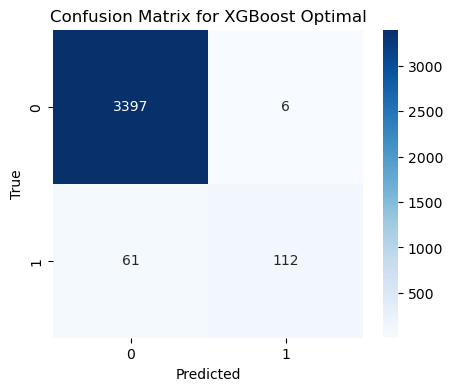

In [87]:
# Confusion Matrix
plt.figure(figsize=(5, 4))
cm = metrics.confusion_matrix(y_test, y_pred_xgb_opt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(y_test)), 
            yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost Optimal')
plt.show()

In [88]:
clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'XGBoost Optimal', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_xgb_opt), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_xgb_opt), 3)})])

clf_results

Model  Accuracy     F1
0    SVM Benchmark     0.968  0.515
0               RF     0.973  0.610
0          XGBoost     0.982  0.776
0  XGBoost Optimal     0.981  0.770

### SMOTE

In [89]:
oversample = SMOTE()

X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [90]:
# check to see if changes passed through

y_train_smote.value_counts()

fraudulent
0    13611
1    13611
Name: count, dtype: int64

### XGBoost with SMOTE

In [91]:
xgb_smote = xgb_model

xgb_smote.fit(X_train_smote, y_train_smote) 
y_pred_xgb_smote = xgb_smote.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_xgb_smote), 3))
print('\n', metrics.classification_report(y_test, y_pred_xgb_smote))

Test set accuracy:  0.98

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3403
           1       0.86      0.69      0.77       173

    accuracy                           0.98      3576
   macro avg       0.92      0.84      0.88      3576
weighted avg       0.98      0.98      0.98      3576



In [92]:
clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'XGBoost SMOTE', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_xgb_smote), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_xgb_smote), 3)})])

clf_results

Model  Accuracy     F1
0    SVM Benchmark     0.968  0.515
0               RF     0.973  0.610
0          XGBoost     0.982  0.776
0  XGBoost Optimal     0.981  0.770
0    XGBoost SMOTE     0.980  0.765

### Undersampling

In [93]:
under = RandomUnderSampler(sampling_strategy = "not minority")

# Apply only on the numerical features for demonstration 
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

In [94]:
y_train_under.value_counts()

fraudulent
0    692
1    692
Name: count, dtype: int64

### XGBoost with Undersampling

In [95]:
xgb_under = xgb_model

xgb_under.fit(X_train_under, y_train_under) 
y_pred_xgb_under = xgb_under.predict(X_test)

print('Test set accuracy: ', round(metrics.accuracy_score(y_test, y_pred_xgb_under), 3))
print('\n', metrics.classification_report(y_test, y_pred_xgb_under))

Test set accuracy:  0.857

               precision    recall  f1-score   support

           0       0.99      0.86      0.92      3403
           1       0.23      0.86      0.37       173

    accuracy                           0.86      3576
   macro avg       0.61      0.86      0.64      3576
weighted avg       0.96      0.86      0.89      3576



In [96]:
clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'XGBoost Undersampling', 
                                                         'Accuracy': round(metrics.accuracy_score(y_test, y_pred_xgb_under), 3), 
                                                         'F1': round(metrics.f1_score(y_test, y_pred_xgb_under), 3)})])

clf_results

Model  Accuracy     F1
0          SVM Benchmark     0.968  0.515
0                     RF     0.973  0.610
0                XGBoost     0.982  0.776
0        XGBoost Optimal     0.981  0.770
0          XGBoost SMOTE     0.980  0.765
0  XGBoost Undersampling     0.857  0.368

### Cross Validation - SMOTE

In [97]:
pipeline_cvsmote = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb_smote)
])

skf_cvsmote = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

f1_cvsmote = make_scorer(f1_score)
skf_cvsmote = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
scores_cvsmote = cross_val_score(pipeline_cvsmote, X_train, y_train, cv=skf_cvsmote, scoring=f1_cvsmote)

print("F1 scores per fold:", scores_cvsmote)
print("Average F1 score:", round(scores_cvsmote.mean(), 2))

F1 scores per fold: [0.70967742 0.66666667 0.60377358 0.76666667 0.64285714 0.6984127
 0.55172414 0.75409836 0.62068966 0.65454545 0.61818182 0.78125
 0.73846154 0.63157895 0.8358209  0.78688525 0.65625    0.68852459
 0.77966102 0.59649123]
Average F1 score: 0.69


In [98]:
clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'XGBoost SMOTE (20-fold CV)', 
                                                         'Accuracy': None, 
                                                         'F1': round(scores_cvsmote.mean(), 3)})])

clf_results

C:\Users\Chris\AppData\Local\Temp\ipykernel_23080\2656439712.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'XGBoost SMOTE (20-fold CV)',


Model  Accuracy     F1
0               SVM Benchmark     0.968  0.515
0                          RF     0.973  0.610
0                     XGBoost     0.982  0.776
0             XGBoost Optimal     0.981  0.770
0               XGBoost SMOTE     0.980  0.765
0       XGBoost Undersampling     0.857  0.368
0  XGBoost SMOTE (20-fold CV)       NaN  0.689

### Cross Validation - Undersampling

In [99]:
pipeline_cvunder = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('xgb', xgb_smote)
])

skf_cvunder = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

f1_cvunder = make_scorer(f1_score)
scores_cvunder = cross_val_score(pipeline_cvunder, X_train, y_train, cv=skf_cvunder, scoring=f1_cvunder)

print("F1 scores per fold:", scores_cvunder)
print("Average F1 score:", round(scores_cvunder.mean(), 2))

F1 scores per fold: [0.36363636 0.28571429 0.31724138 0.32967033 0.30681818 0.32085561
 0.28421053 0.32748538 0.31372549 0.27956989 0.25806452 0.33142857
 0.33695652 0.30952381 0.34090909 0.33333333 0.33526012 0.34285714
 0.39473684 0.33918129]
Average F1 score: 0.32


In [100]:
clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'XGBoost Undersampling (20-fold CV)', 
                                                         'Accuracy': None, 
                                                         'F1': round(scores_cvunder.mean(), 3)})])

clf_results

C:\Users\Chris\AppData\Local\Temp\ipykernel_23080\2010942997.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'XGBoost Undersampling (20-fold CV)',


Model  Accuracy     F1
0                       SVM Benchmark     0.968  0.515
0                                  RF     0.973  0.610
0                             XGBoost     0.982  0.776
0                     XGBoost Optimal     0.981  0.770
0                       XGBoost SMOTE     0.980  0.765
0               XGBoost Undersampling     0.857  0.368
0          XGBoost SMOTE (20-fold CV)       NaN  0.689
0  XGBoost Undersampling (20-fold CV)       NaN  0.323

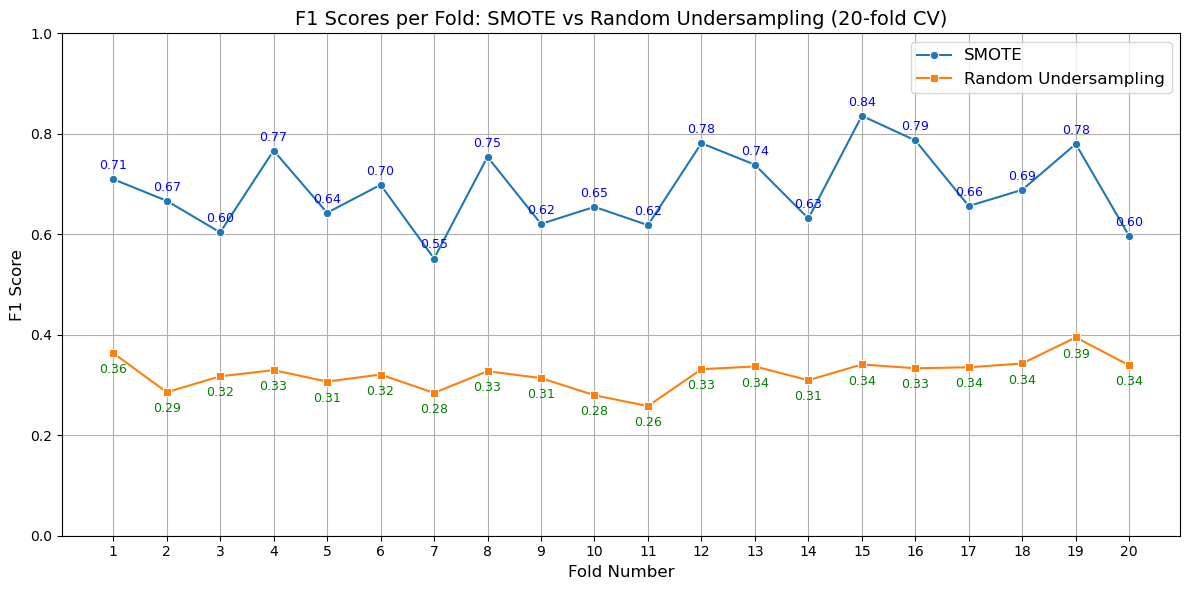

In [101]:
folds = np.arange(1, 21)


plt.figure(figsize=(12, 6))
sns.lineplot(x=folds, y=scores_cvsmote, marker='o', label='SMOTE')
sns.lineplot(x=folds, y=scores_cvunder, marker='s', label='Random Undersampling')

for i, score in enumerate(scores_cvsmote):
    plt.text(folds[i], score + 0.02, f"{score:.2f}", ha='center', fontsize=9, color='blue')

for i, score in enumerate(scores_cvunder):
    plt.text(folds[i], score - 0.04, f"{score:.2f}", ha='center', fontsize=9, color='green')

plt.title('F1 Scores per Fold: SMOTE vs Random Undersampling (20-fold CV)', fontsize=14)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(folds)
plt.ylim(0, 1)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### Deep learning

### Tokenize and Build Vocab

In [102]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, max_len: int = 20):
        self.max_len = max_len

        self.texts = [t.lower().split() for t in texts]
        self.labels = labels

        if vocab is None:
            counter = Counter(word for text in self.texts for word in text)
            self.vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.most_common())}
            self.vocab['<PAD>'] = 0
            self.vocab['<UNK>'] = 1
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def encode_text(self, text):
        # Map every word to its ID, defaulting to <UNK> (1) when necessary.
        ids = [self.vocab.get(word, self.vocab['<UNK>']) for word in text]

        # Pad or truncate to fixed length so that we can stack multiple
        # samples into a single tensor of shape (batch_size, max_len).
        if len(ids) < self.max_len:
            # Add as many <PAD> (0) tokens as needed.
            ids += [self.vocab['<PAD>']] * (self.max_len - len(ids))
        else:
            ids = ids[: self.max_len]

        return torch.tensor(ids)

    def __getitem__(self, idx):
        # Fetch the already-tokenised sentence and convert it to IDs.
        text_tensor = self.encode_text(self.texts[idx])

        label_tensor = torch.tensor(self.labels[idx])

        return text_tensor, label_tensor

### DL Model Implementation

In [103]:
# This is the class for the deep learning model. nn.Module is the parent class for all neural network modules in PyTorch.
class DLModel(nn.Module):
    def __init__(
        self, # This is the self parameter, which is the instance of the class
        vocab_size, # This is the size of the vocabulary
        embed_dim, # This is the dimension of the embedding layer
        hidden_dim, # This is the dimension of the hidden layer
        output_dim, # This is the dimension of the output layer
        model_type, # This is the type of the model
        num_layers=1, # This is the number of layers in the model
        dropout_prob=0.5 # This is the dropout probability
    ):
        super().__init__() # This is the super() function, which is the parent class of the class
        # Initialize the embedding layer with the given vocabulary size and embedding dimension
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Initialize the recurrent layer based on the specified model type
        if model_type == 'RNN':
            # Use RNN with specified parameters
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                              dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        elif model_type == 'LSTM':
            # Use LSTM with specified parameters
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                               dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        elif model_type == 'GRU':
            # Use GRU with specified parameters
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers,
                              dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        else:
            # Raise an error if an unsupported model type is provided
            raise ValueError('model_type must be RNN, LSTM, or GRU')

        # Initialize batch normalization for the hidden layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        # Initialize dropout for regularization
        self.dropout = nn.Dropout(dropout_prob)
        # Initialize the fully connected layer for output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Embed the input sequence
        embedded = self.embedding(x)  # Shape: [batch_size, seq_len, embed_dim]
        # Pass the embedded sequence through the recurrent layer
        output, hidden = self.rnn(embedded)

        # Check if the hidden state is a tuple (for LSTM)
        if isinstance(hidden, tuple):  # For LSTM
            hidden = hidden[0]  # Use the hidden state, not the cell state

        # Use the last layer's hidden state
        hidden = hidden[-1]  # Shape: [batch_size, hidden_dim]
        # Apply batch normalization
        hidden = self.batch_norm(hidden)  # BatchNorm expects shape [batch_size, features]
        # Apply dropout for regularization
        hidden = self.dropout(hidden)
        # Pass through the fully connected layer to get the output
        out = self.fc(hidden)
        return out  # Return the final output

### Data Preparation

In [104]:
X = df['description'] 
y = df['fraudulent'] 

In [105]:
# Convert the 'df_summary' column of the DataFrame to a list of texts
texts = X.tolist()
# Display the first 5 elements of the list for inspection
texts[:5]

['food fastgrowing james beard awardwinning online food community crowdsourced curated recipe hub currently interview full parttime unpaid interns work small team editor executive developer new york city headquarters reproduce andor repackaging exist food content number partner sit huffington post yahoo buzzfeed various content management system research blogs website provision food affiliate program assist daytoday affiliate program support screen affiliate assist affiliate inquiry support amp event need help office administrative work filing mail preparing meeting work developer document bug suggest improvement site support marketing executive staff',
 'organise focused vibrant awesome passion customer service slick type skill maybe account management think administration cooler polar bear jetski need hear cloud video production service opperating glodal level yeah pretty cool serious deliver world class product excellent customer service rapidly expand business look talented project

In [106]:
# Convert the 'df_score' column of the DataFrame to a list of integer labels
labels = y.astype(int).tolist()
# Display the first 5 elements of the labels list for inspection
labels[:5]

[0, 0, 0, 0, 0]

In [107]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

In [108]:
lengths = [len(t.lower().split()) for t in train_texts]
max_len = int(np.percentile(lengths, 95))  
max_len

255

In [109]:
train_dataset = TextDataset(train_texts, train_labels, max_len=max_len)
test_dataset = TextDataset(test_texts, test_labels, vocab=train_dataset.vocab, max_len=max_len)

In [110]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Hyperparameters

In [111]:
# Determine the size of the vocabulary from the training dataset
vocab_size = len(train_dataset.vocab)
# Set the embedding dimension for the model
embed_dim = 384
# Set the hidden layer dimension for the model
hidden_dim = 256
# Define the output dimension, corresponding to the number of classes 
output_dim = 2 
# Specify the type of model to use; options include 'RNN', 'LSTM', or 'GRU'
model_type = 'GRU'  
# Set the number of layers in the model
number_of_layers = 1

### Model, loss, optimizer

In [112]:
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Display the device being used (either 'cuda' for GPU or 'cpu' for CPU)
device

device(type='cuda')

In [113]:
model = DLModel(vocab_size, embed_dim, hidden_dim, output_dim, model_type, num_layers=number_of_layers).to(device)

In [114]:
criterion = nn.CrossEntropyLoss()

In [115]:
optimizer = optim.Adam(model.parameters())
nof_epochs = 5

In [116]:
def evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, epoch, train_loss):
    # Initialize variables to track test loss and correct predictions
    test_loss = 0
    correct_train = 0
    correct_test = 0
    total_train = 0
    total_test = 0

    # Calculate train accuracy
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
            outputs = model(inputs)  # Forward pass: compute model output
            preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability
            correct_train += (preds == targets).sum().item()  # Count correct predictions
            total_train += targets.size(0)  # Count total samples
    train_accuracy = correct_train / total_train  # Calculate train accuracy
    train_accuracies.append(train_accuracy)  # Append train accuracy to the list

    # Calculate test loss and accuracy
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
            outputs = model(inputs)  # Forward pass: compute model output
            loss = criterion(outputs, targets)  # Compute loss
            test_loss += loss.item()  # Accumulate test loss
            preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability
            correct_test += (preds == targets).sum().item()  # Count correct predictions
            total_test += targets.size(0)  # Count total samples
    test_loss /= len(test_loader)  # Average test loss over all batches
    test_losses.append(test_loss)  # Append test loss to the list
    test_accuracy = correct_test / total_test  # Calculate test accuracy
    test_accuracies.append(test_accuracy)  # Append test accuracy to the list

    print(100*"=")  # Print separator for readability
    # Print current epoch, train loss, test loss, train accuracy, and test accuracy
    print(f"{datetime.now().replace(microsecond=0)}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(100*"=")  # Print separator for readability

In [117]:
start_time = time.time()

In [118]:
# Initialize lists to store training and testing accuracies for each epoch
train_accuracies = []
test_accuracies = []

# Initialize lists to store training and testing losses for each epoch
train_losses = []
test_losses = []

### Initial Accuracy

In [119]:
train_loss = sum(criterion(model(inputs.to(device)), targets.to(device)).item() for inputs, targets in train_loader) / len(train_loader)
train_losses.append(train_loss)
train_loss

0.755453852138349

In [120]:
evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, -1, train_loss)

2025-07-24 11:08:33, Epoch 0, Train Loss: 0.7555, Test Loss: 0.7273, Train Accuracy: 0.9193, Test Accuracy: 0.9161


### Training Loop

In [121]:
# Loop over each epoch
for epoch in range(nof_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize training loss for the current epoch
    # Loop over each batch in the training data
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device

        optimizer.zero_grad()  # Reset gradients for the optimizer
        outputs = model(inputs)  # Forward pass: compute model output
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model parameters

        train_loss += loss.item()  # Accumulate training loss

        # Print progress every 10% of the training data
        if idx % (len(train_loader) // 10) == 0:
           print(f"{datetime.now().replace(microsecond=0)}, Epoch {epoch+1}, Batch {idx+1}/{len(train_loader)}, Train Loss: {train_loss/(idx+1):.4f}, Elapsed: {(time.time() - start_time)/60:.5f} min")
    train_loss = train_loss / len(train_loader)  # Average training loss over all batches
    train_losses.append(train_loss)  # Append training loss to the list

    # Evaluate the model on training and test data
    evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, epoch, train_loss)

2025-07-24 11:08:34, Epoch 1, Batch 1/224, Train Loss: 0.6435, Elapsed: 0.10043 min
2025-07-24 11:08:34, Epoch 1, Batch 23/224, Train Loss: 0.7036, Elapsed: 0.10815 min
2025-07-24 11:08:35, Epoch 1, Batch 45/224, Train Loss: 0.6430, Elapsed: 0.11576 min
2025-07-24 11:08:35, Epoch 1, Batch 67/224, Train Loss: 0.5924, Elapsed: 0.12340 min
2025-07-24 11:08:35, Epoch 1, Batch 89/224, Train Loss: 0.5438, Elapsed: 0.13103 min
2025-07-24 11:08:36, Epoch 1, Batch 111/224, Train Loss: 0.5044, Elapsed: 0.13860 min
2025-07-24 11:08:36, Epoch 1, Batch 133/224, Train Loss: 0.4769, Elapsed: 0.14618 min
2025-07-24 11:08:37, Epoch 1, Batch 155/224, Train Loss: 0.4478, Elapsed: 0.15381 min
2025-07-24 11:08:37, Epoch 1, Batch 177/224, Train Loss: 0.4208, Elapsed: 0.16138 min
2025-07-24 11:08:38, Epoch 1, Batch 199/224, Train Loss: 0.3994, Elapsed: 0.16898 min
2025-07-24 11:08:38, Epoch 1, Batch 221/224, Train Loss: 0.3803, Elapsed: 0.17660 min
2025-07-24 11:08:41, Epoch 1, Train Loss: 0.3776, Test Loss:

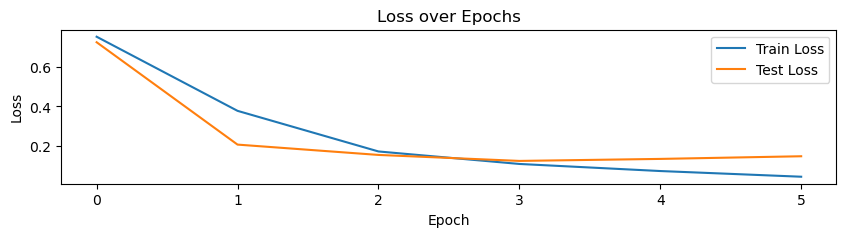

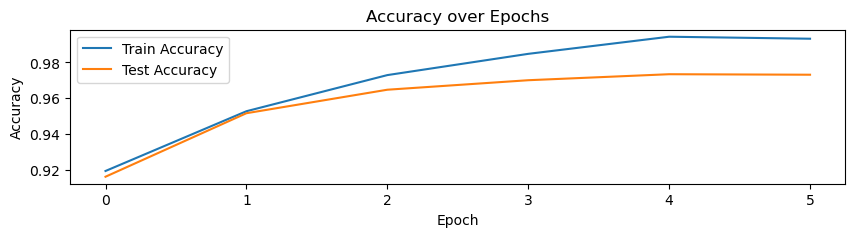

In [122]:
# Plot training and test loss
plt.figure(figsize=(10, 2))  # Create a new figure with a specified size
plt.plot(train_losses, label='Train Loss')  # Plot the training loss with a label
plt.plot(test_losses, label='Test Loss')  # Plot the test loss with a label
plt.title('Loss over Epochs')  # Set the title of the plot
plt.xlabel('Epoch')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.legend()  # Display the legend to differentiate between plots
plt.show()  # Show the plot

# Plot training and test accuracy
plt.figure(figsize=(10, 2))  # Create another figure for accuracy plots
plt.plot(train_accuracies, label='Train Accuracy')  # Plot the training accuracy with a label
plt.plot(test_accuracies, label='Test Accuracy')  # Plot the test accuracy with a label
plt.title('Accuracy over Epochs')  # Set the title of the accuracy plot
plt.xlabel('Epoch')  # Set the x-axis label for accuracy
plt.ylabel('Accuracy')  # Set the y-axis label for accuracy
plt.legend()  # Display the legend for accuracy plots
plt.show()  # Show the accuracy plot

### Final Accuracy

In [123]:
# test set
model.eval()  # Set the model to evaluation mode
all_preds = []  # Initialize a list to store all predictions
all_targets = []  # Initialize a list to store all true targets

with torch.no_grad():  # Disable gradient calculation for efficiency
    for inputs, targets in test_loader:  # Iterate over the test data
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
        outputs = model(inputs)  # Get model outputs
        preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())  # Append predictions to the list, converting to numpy array
        all_targets.extend(targets.cpu().numpy())  # Append true targets to the list, converting to numpy array

report = classification_report(all_targets, all_preds, digits=4, output_dict=True)

print(classification_report(all_targets, all_preds, digits=4))  # Print a detailed classification report

accuracy_gru = report['accuracy']
f1_gru = report['1']['f1-score']  # Assuming "1" = fake class

              precision    recall  f1-score   support

           0     0.9778    0.9944    0.9860      3403
           1     0.8348    0.5549    0.6667       173

    accuracy                         0.9732      3576
   macro avg     0.9063    0.7747    0.8263      3576
weighted avg     0.9708    0.9732    0.9706      3576



In [124]:
# train set
model.eval()  # Set the model to evaluation mode to disable dropout and batch normalization

all_preds = []  # Initialize a list to store predictions from the model
all_targets = []  # Initialize a list to store true target values

with torch.no_grad():  # Disable gradient calculation for efficiency during evaluation
    for inputs, targets in train_loader:  # Iterate over the training data
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device (CPU or GPU)
        outputs = model(inputs)  # Get model outputs for the inputs
        preds = outputs.argmax(dim=1)  # Determine predicted class by finding the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())  # Append predictions to the list, converting to numpy array
        all_targets.extend(targets.cpu().numpy())  # Append true targets to the list, converting to numpy array

# Print classification report
print(classification_report(all_targets, all_preds, digits=4))  # Print a detailed classification report with 4 decimal places

              precision    recall  f1-score   support

           0     0.9932    0.9998    0.9965     13611
           1     0.9950    0.8656    0.9258       692

    accuracy                         0.9933     14303
   macro avg     0.9941    0.9327    0.9611     14303
weighted avg     0.9933    0.9933    0.9931     14303



In [125]:
clf_results = pd.concat([clf_results, pd.json_normalize({'Model': 'GRU',  
                                                         'Accuracy': round(accuracy_gru, 4),
                                                         'F1': round(f1_gru, 4),})])
clf_results

Model  Accuracy      F1
0                       SVM Benchmark    0.9680  0.5150
0                                  RF    0.9730  0.6100
0                             XGBoost    0.9820  0.7760
0                     XGBoost Optimal    0.9810  0.7700
0                       XGBoost SMOTE    0.9800  0.7650
0               XGBoost Undersampling    0.8570  0.3680
0          XGBoost SMOTE (20-fold CV)       NaN  0.6890
0  XGBoost Undersampling (20-fold CV)       NaN  0.3230
0                                 GRU    0.9732  0.6667

In [126]:
# compare all models

clf_results.sort_values(by='F1', ascending=False, inplace=True)
clf_results

Model  Accuracy      F1
0                             XGBoost    0.9820  0.7760
0                     XGBoost Optimal    0.9810  0.7700
0                       XGBoost SMOTE    0.9800  0.7650
0          XGBoost SMOTE (20-fold CV)       NaN  0.6890
0                                 GRU    0.9732  0.6667
0                                  RF    0.9730  0.6100
0                       SVM Benchmark    0.9680  0.5150
0               XGBoost Undersampling    0.8570  0.3680
0  XGBoost Undersampling (20-fold CV)       NaN  0.3230

C:\Users\Chris\AppData\Local\Temp\ipykernel_23080\4218588281.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=clf_results, x='F1', y='Model', palette='summer')


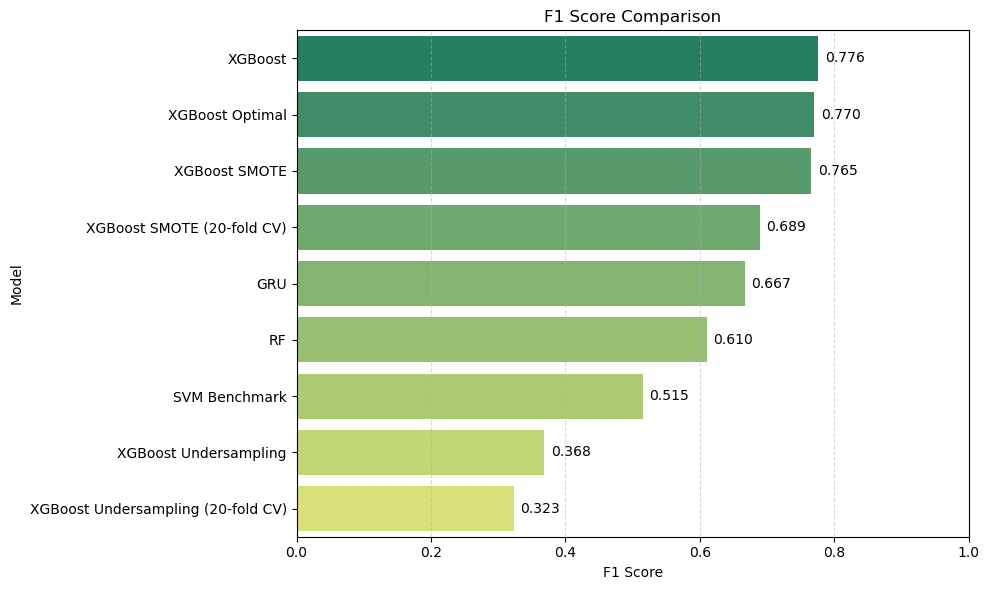

In [127]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=clf_results, x='F1', y='Model', palette='summer')

for i, (f1, model) in enumerate(zip(clf_results['F1'], clf_results['Model'])):
    plt.text(f1 + 0.01, i, f"{f1:.3f}", va='center', fontsize=10)

plt.title('F1 Score Comparison')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Lime

In [128]:
X = df['description'] 
y = df['fraudulent'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2), stop_words='english'),
    LogisticRegression(max_iter=1000)
)

pipeline.fit(X_train, y_train)

class_names = ['Real', 'Fraudulent']  
explainer = LimeTextExplainer(class_names=class_names)

idx = 100
sample_text = X_test.iloc[idx]

exp = explainer.explain_instance(
    sample_text,
    pipeline.predict_proba,
    num_features=10
)

C:\Users\Chris\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:455: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(


<Figure size 1200x800 with 0 Axes>

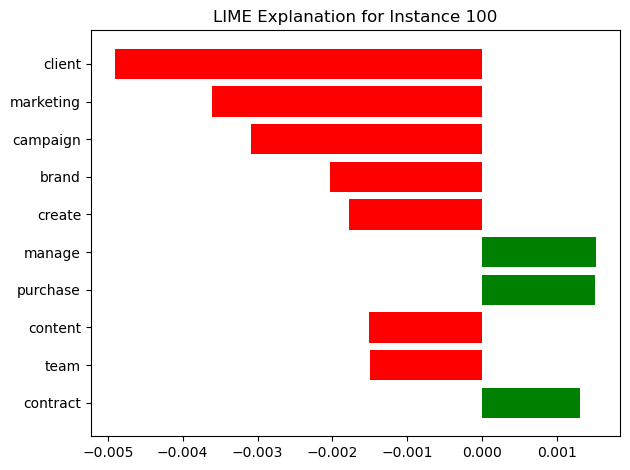

In [129]:
# Plot LIME explanation
plt.figure(figsize=(12, 8))
exp.as_pyplot_figure()
plt.title(f'LIME Explanation for Instance {idx}')
plt.tight_layout()
plt.show()

# Unsupervised

## Data import and preprocessing

In [130]:
df.head()

job_id                                    title    location  \
0       1                         marketing intern    new york   
1       2  customer service cloud video production    auckland   
2       3       commission machinery assistant cma       wever   
3       4             account executive washington  washington   
4       5                      bill review manager  fort worth   

           department  salary_range  \
0           marketing  not disclose   
1             success  not disclose   
2  department unknown  not disclose   
3                sale  not disclose   
4  department unknown  not disclose   

                                     company_profile  \
0  food weve create groundbreaking awardwinning c...   
1  second world cloud video production service se...   
2  valor service provide workforce solution meet ...   
3  passion improve quality life geography heart e...   
4  spot source solution llc global human capital ...   

                                         description  \
0  food fastgrowing james beard awardwinning onli...   
1  organise focused vibrant awesome passion custo...   
2  client locate houston actively seek experience...   
3  company esri environmental system research ins...   
4  job title itemization review manager location ...   

                                        requirements  \
0  experience content management system major plu...   
1  expect youyour key responsibility communicate ...   
2  implement precommissioning commission procedur...   
3  education bachelor master gi business administ...   
4  qualificationsrn license state texas diploma b...   

                                            benefits  telecommuting  \
0                                benefit not mention              0   
1  get part second team gainexperience work proje...              0   
2                                benefit not mention              0   
3  culture anything corporatewe collaborative cre...              0   
4                                 full benefit offer              0   

   has_company_logo  has_questions     employment_type required_experience  \
0                 1              0                              internship   
1                 1              0            fulltime      not applicable   
2                 1              0  employment unknown  experience unknown   
3                 1              0            fulltime     midsenior level   
4                 1              1            fulltime     midsenior level   

  required_education               industry              function  fraudulent  
0  education unknown       industry unknown             marketing           0  
1  education unknown  marketing advertising      customer service           0  
2  education unknown       industry unknown      function unknown           0  
3    bachelor degree      computer software                  sale           0  
4    bachelor degree   hospital health care  health care provider           0

In [131]:
df_description=df["description"]

### Convert description to list of texts and tokenizing




In [132]:
my_texts = df['description'].astype(str).tolist()
my_texts[:5]

['food fastgrowing james beard awardwinning online food community crowdsourced curated recipe hub currently interview full parttime unpaid interns work small team editor executive developer new york city headquarters reproduce andor repackaging exist food content number partner sit huffington post yahoo buzzfeed various content management system research blogs website provision food affiliate program assist daytoday affiliate program support screen affiliate assist affiliate inquiry support amp event need help office administrative work filing mail preparing meeting work developer document bug suggest improvement site support marketing executive staff',
 'organise focused vibrant awesome passion customer service slick type skill maybe account management think administration cooler polar bear jetski need hear cloud video production service opperating glodal level yeah pretty cool serious deliver world class product excellent customer service rapidly expand business look talented project

In [133]:
processed_texts = [my_text.split() for my_text in my_texts]
processed_texts[:5]

[['food',
  'fastgrowing',
  'james',
  'beard',
  'awardwinning',
  'online',
  'food',
  'community',
  'crowdsourced',
  'curated',
  'recipe',
  'hub',
  'currently',
  'interview',
  'full',
  'parttime',
  'unpaid',
  'interns',
  'work',
  'small',
  'team',
  'editor',
  'executive',
  'developer',
  'new',
  'york',
  'city',
  'headquarters',
  'reproduce',
  'andor',
  'repackaging',
  'exist',
  'food',
  'content',
  'number',
  'partner',
  'sit',
  'huffington',
  'post',
  'yahoo',
  'buzzfeed',
  'various',
  'content',
  'management',
  'system',
  'research',
  'blogs',
  'website',
  'provision',
  'food',
  'affiliate',
  'program',
  'assist',
  'daytoday',
  'affiliate',
  'program',
  'support',
  'screen',
  'affiliate',
  'assist',
  'affiliate',
  'inquiry',
  'support',
  'amp',
  'event',
  'need',
  'help',
  'office',
  'administrative',
  'work',
  'filing',
  'mail',
  'preparing',
  'meeting',
  'work',
  'developer',
  'document',
  'bug',
  'suggest'

### Create a dictionary, filter extreme values and create the document-term matrix to prepare for unsupervised learning

In [134]:
my_dictionary = corpora.Dictionary(processed_texts)
my_dictionary

In [135]:
# Print 10 random items from the dictionary to understand its structure
print("10 random items from the dictionary:")
random_ids = random.sample(list(my_dictionary.keys()), 10)
for word_id in random_ids:
    print(f"Word ID {word_id}: {my_dictionary[word_id]}")

10 random items from the dictionary:
Word ID 35741: utilityhydroelectrical
Word ID 5697: captive
Word ID 38698: responsibilitiesmaintaining
Word ID 27651: behold
Word ID 2082: addonsmetatrader
Word ID 1952: pgi
Word ID 6140: msoparamarginbottom
Word ID 14328: vagrant
Word ID 15247: emailccacbefcfdaddacbadecfbdbcdabecdc
Word ID 33118: ownerceo


In [136]:
len(my_dictionary)

43168

In [137]:
my_dictionary.filter_extremes(no_below=10, no_above=0.1)
my_dictionary

In [138]:
len(my_dictionary)

7420

In [139]:
my_corpus = [my_dictionary.doc2bow(text) for text in processed_texts]

In [140]:
my_corpus[:10]

[[(0, 1),
  (1, 4),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 2),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 4),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1)],
 [(9, 1),
  (31, 2),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 3),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 4),
  (67, 1),
  (68, 2),
  (69, 1),
  (70, 3),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 2),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 2),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1)

In [141]:
# print the first 10 documents in the corpus, their words and their IDs
for doc_id, doc in enumerate(my_corpus[:10]):
    print(f"Document {doc_id+1}:")
    for word_id, freq in doc:
        word = my_dictionary[word_id]
        print(f"  Word ID {word_id} ('{word}'): Frequency {freq}")

Document 1:
  Word ID 0 ('administrative'): Frequency 1
  Word ID 1 ('affiliate'): Frequency 4
  Word ID 2 ('andor'): Frequency 1
  Word ID 3 ('awardwinning'): Frequency 1
  Word ID 4 ('beard'): Frequency 1
  Word ID 5 ('blogs'): Frequency 1
  Word ID 6 ('bug'): Frequency 1
  Word ID 7 ('city'): Frequency 1
  Word ID 8 ('community'): Frequency 1
  Word ID 9 ('content'): Frequency 2
  Word ID 10 ('crowdsourced'): Frequency 1
  Word ID 11 ('curated'): Frequency 1
  Word ID 12 ('daytoday'): Frequency 1
  Word ID 13 ('document'): Frequency 1
  Word ID 14 ('editor'): Frequency 1
  Word ID 15 ('event'): Frequency 1
  Word ID 16 ('executive'): Frequency 2
  Word ID 17 ('exist'): Frequency 1
  Word ID 18 ('fastgrowing'): Frequency 1
  Word ID 19 ('filing'): Frequency 1
  Word ID 20 ('food'): Frequency 4
  Word ID 21 ('headquarters'): Frequency 1
  Word ID 22 ('hub'): Frequency 1
  Word ID 23 ('huffington'): Frequency 1
  Word ID 24 ('improvement'): Frequency 1
  Word ID 25 ('inquiry'): Frequen

## LDA Unsupervised Learning

### LDA training and evaluating

In [142]:
#testing out a range of differnt parameters and storing results in DF
num_topic_range = range(2, 21, 2)  # steps of 2 ranging from 2 to 20 topics
my_passes = 10 # Number of my_passes of the corpus through the model during training. More my_passes means better accuracy but longer runtime
workers = 4  # Number of worker processes for parallel computing
results = [] #to store outcomes

### Train LDA model

In [143]:
#for-loop loops through each number of topics in the range we specified above, trains the model and calculates both scores
for num_topics in num_topic_range:
  print(f"\nLDA model with {num_topics} topics")

  lda_model = LdaMulticore(
    corpus=my_corpus, # The document-term list we created earlier
    id2word=my_dictionary, # Maps word IDs to actual words for interpretable output
    num_topics=num_topics, # Number of topics to extract
    passes=my_passes, # Number of training my_passes through the corpus
    workers=workers, # Number of parallel processes to use
    alpha='symmetric', # Topic distribution prior - 'symmetric' gives equal probability to all topics initially
    eta='auto', # Word distribution prior (influences how words are distributed across topics). 'auto' lets the model learn optimal word weights. β in notes.
    random_state = 42 #maintain replicability
    )
  coherence_model_lda = CoherenceModel(model=lda_model, # LDA model
                                     texts=processed_texts, # list of texts, each text is a list of words
                                     dictionary=my_dictionary, # dictionary of words and their IDs
                                     coherence='c_v', # coherence measure, c_v id defined as the average pointwise mutual information of all word pairs in a topic
                                     topn=20 # number of words to consider for coherence score
                                     )
  coherence_score = coherence_model_lda.get_coherence()
  perplexity = lda_model.log_perplexity(my_corpus)
  print(f"Coherence Score: {coherence_score:.4f}")
  print(f"Perplexity: {perplexity:.4f}")
  results.append({
      'num_topics': num_topics,
      'coherence': coherence_score,
      'perplexity': perplexity
  })

  print(results)


LDA model with 2 topics
Coherence Score: 0.5022
Perplexity: -7.7310
[{'num_topics': 2, 'coherence': 0.5022453480276471, 'perplexity': -7.731015220441365}]

LDA model with 4 topics
Coherence Score: 0.4985
Perplexity: -7.6353
[{'num_topics': 2, 'coherence': 0.5022453480276471, 'perplexity': -7.731015220441365}, {'num_topics': 4, 'coherence': 0.4985040614229165, 'perplexity': -7.635329443025507}]

LDA model with 6 topics
Coherence Score: 0.4327
Perplexity: -7.5806
[{'num_topics': 2, 'coherence': 0.5022453480276471, 'perplexity': -7.731015220441365}, {'num_topics': 4, 'coherence': 0.4985040614229165, 'perplexity': -7.635329443025507}, {'num_topics': 6, 'coherence': 0.4327377452651415, 'perplexity': -7.580604753032413}]

LDA model with 8 topics
Coherence Score: 0.4398
Perplexity: -7.5500
[{'num_topics': 2, 'coherence': 0.5022453480276471, 'perplexity': -7.731015220441365}, {'num_topics': 4, 'coherence': 0.4985040614229165, 'perplexity': -7.635329443025507}, {'num_topics': 6, 'coherence': 0

In [144]:
results_df = pd.DataFrame(results)
print(results_df)

   num_topics  coherence  perplexity
0           2   0.502245   -7.731015
1           4   0.498504   -7.635329
2           6   0.432738   -7.580605
3           8   0.439770   -7.550013
4          10   0.496586   -7.525402
5          12   0.518609   -7.477121
6          14   0.483253   -7.467828
7          16   0.528208   -7.425799
8          18   0.550610   -7.401229
9          20   0.553850   -7.399852


In [145]:
best_num_topics = max(results, key=lambda x: x['coherence'])['num_topics']

In [146]:
#best number of topics based on highest coherence and lowest perplexity is 6
best_lda_model = LdaMulticore(
    corpus=my_corpus, # The document-term list we created earlier
    id2word=my_dictionary, # Maps word IDs to actual words for interpretable output
    num_topics= best_num_topics, # Number of topics to extract
    passes=my_passes, # Number of training my_passes through the corpus
    workers=workers, # Number of parallel processes to use
    alpha='symmetric', # Topic distribution prior - 'symmetric' gives equal probability to all topics initially
    eta='auto', # Word distribution prior (influences how words are distributed across topics). 'auto' lets the model learn optimal word weights. β in notes.
    random_state = 0 #maintain replicability
    )

In [147]:
# Prepare the visualization
vis_data = gensimvis.prepare(best_lda_model, my_corpus, my_dictionary)

# Set the figure size for better visualization
pyLDAvis.enable_notebook()

# Display the interactive visualization
pyLDAvis.display(vis_data)

In [148]:
# Select 10 random document indices
random_doc_indices = random.sample(range(len(my_corpus)), 10)

print("\nTopic Distribution for 10 Random Documents:")
print("-" * 50)

for idx in random_doc_indices:
    # Get the document's topic distribution
    doc_topics = best_lda_model.get_document_topics(my_corpus[idx])

    # Sort topics by probability (highest first)
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Get the original text (if available)
    original_text = df["description"].iloc[idx]

    print(f"\nDocument {idx}: \"{original_text}\"")
    print("Topic Distribution:")

    for topic_id, prob in doc_topics[:3]:
        # Get the top words for this topic
        topic_words = best_lda_model.show_topic(topic_id, topn=5)
        words = ", ".join([word for word, _ in topic_words])

        # Format the probability as a percentage
        prob_percent = prob * 100

        print(f"  Topic {topic_id+1}: {prob_percent:.2f}% ({words})")


Topic Distribution for 10 Random Documents:
--------------------------------------------------

Document 6515: "seek experience salesforce developer look responsible selfstarter possesses selfmanagement skill deep knowledge salesforce join team position perfect season salesforce user preferably administer salesforce account contract position project look develop good work relationship salesforce developeradmin long term hop create mutually beneficial partnership currently salesforce account utilizes sale cloud enterprise account url platform knowledge base url clean prospector partner portal ideal candidate year salesforce experience ability design write debug server side application apex ability write integrate html cs java script ability work salesforce development platform strong understanding practice software development process architecture design pattern specifically salesforce ability communicate effectively orally write posse indepth work knowledge salesurl evaluate business 

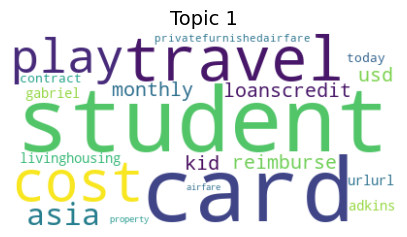

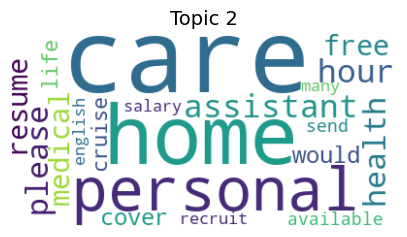

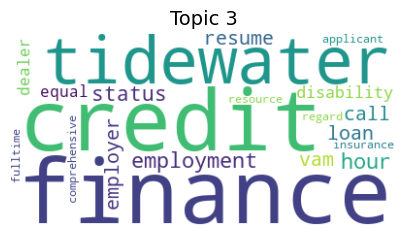

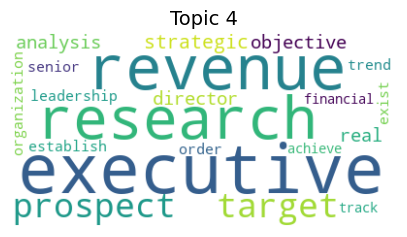

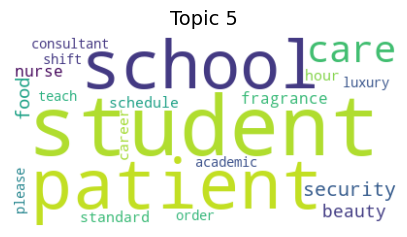

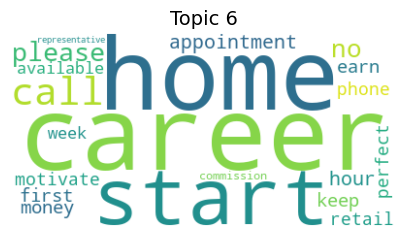

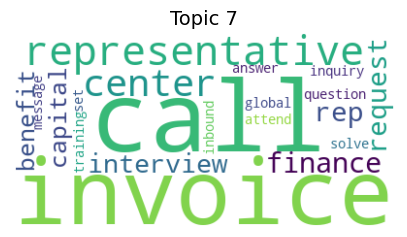

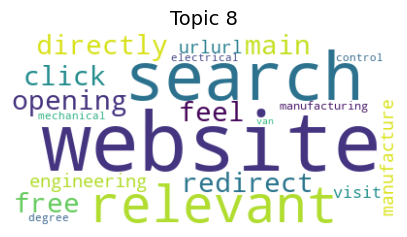

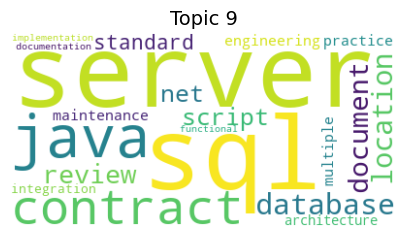

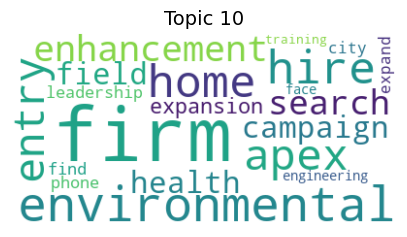

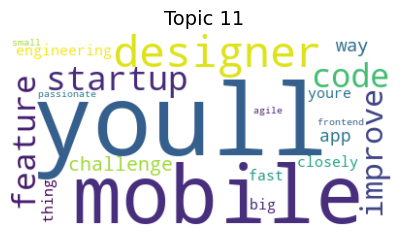

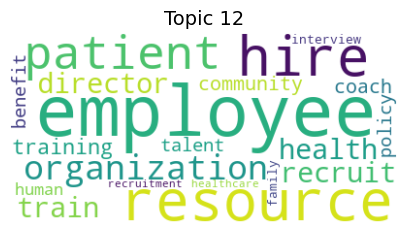

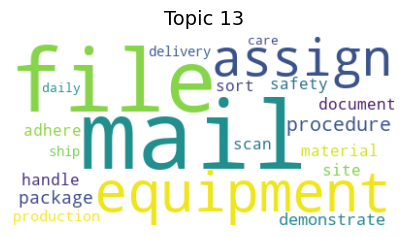

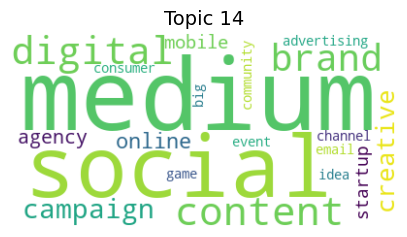

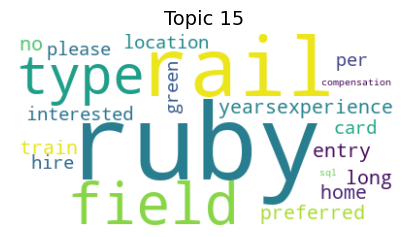

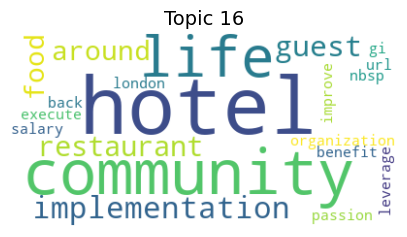

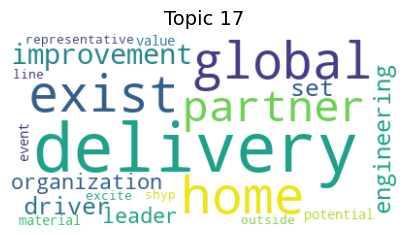

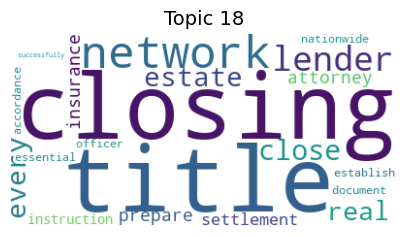

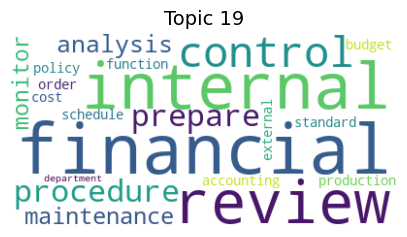

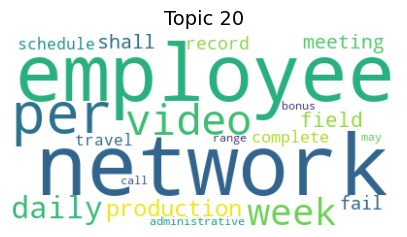

In [149]:
#idea from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document
# Number of topics you want to visualize
num_topics = best_num_topics

# Create one plot per topic
for topic_id in range(num_topics):
    plt.figure(figsize=(5, 5))

    # Get top words for the topic
    topic_words = dict(best_lda_model.show_topic(topic_id, topn=20))

    # Generate and display word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(topic_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id+1}", fontsize=14)
    plt.show()


## MDS Unsupervised Learning


In [150]:
# Create a list of unique words
unique_words = [word for sublist in processed_texts for word in sublist]
print(len(set(unique_words)))
unique_words[:15]

43168


['food',
 'fastgrowing',
 'james',
 'beard',
 'awardwinning',
 'online',
 'food',
 'community',
 'crowdsourced',
 'curated',
 'recipe',
 'hub',
 'currently',
 'interview',
 'full']

In [151]:
word_counts = Counter(unique_words)
word_counts

Counter({'work': 23312,
         'team': 21810,
         'customer': 15631,
         'service': 13556,
         'experience': 13268,
         'product': 12284,
         'business': 12049,
         'company': 11914,
         'client': 11817,
         'provide': 10044,
         'new': 9807,
         'sale': 9626,
         'look': 9420,
         'project': 9065,
         'support': 8940,
         'development': 8633,
         'include': 8511,
         'management': 8113,
         'design': 7880,
         'job': 7590,
         'need': 7453,
         'position': 7291,
         'develop': 7102,
         'opportunity': 7097,
         'ensure': 6941,
         'process': 6348,
         'help': 6342,
         'manage': 6298,
         'amp': 6220,
         'skill': 6175,
         'manager': 6146,
         'system': 6041,
         'maintain': 5950,
         'role': 5905,
         'lead': 5880,
         'candidate': 5864,
         'data': 5844,
         'use': 5664,
         'technology': 5519,
   

In [152]:
unique_words = [word for word, count in word_counts.most_common(len(set(unique_words)))]
unique_words[:5]

['work', 'team', 'customer', 'service', 'experience']

In [153]:
# Create a word index dictionary
word_index = {word: idx for idx, word in enumerate(unique_words)}
# Define context window as a parameter
context_window = 3

In [154]:
# Initialize the contingency matrix
import numpy as np
contingency_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

# Populate the contingency matrix with the defined context window
for iter_sentence, sentence in enumerate(processed_texts):
    for i in range(len(sentence)):
        for j in range(max(0, i - context_window), min(len(sentence), i + context_window + 1)):
            if i != j:
                if sentence[i] in word_index and sentence[j] in word_index:
                    contingency_matrix[word_index[sentence[i]], word_index[sentence[j]]] += 1
    if iter_sentence % 100_000 == 0:
        print(iter_sentence)

0


In [155]:
contingency_matrix

array([[1118, 3719,  899, ...,    0,    0,    0],
       [3719,  988,  877, ...,    0,    0,    0],
       [ 899,  877, 1106, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [156]:
embeddings_dim = 2

In [157]:
nof_obj = contingency_matrix.shape[0]
np.random.seed(0)
embeddings_matrix = 2*np.random.rand(nof_obj, embeddings_dim)-1
print(embeddings_matrix.shape)
embeddings_matrix

(43168, 2)


array([[ 0.09762701,  0.43037873],
       [ 0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823],
       ...,
       [ 0.93064017, -0.13663177],
       [ 0.33078068, -0.46776099],
       [-0.98051047,  0.94602429]])

In [158]:
sum_weights_all = []
idxs_all = []
nof_nearest_neighbors = 5
for i in range(nof_obj):
    weights = contingency_matrix[i]
    idxs = np.arange(len(weights))[np.arange(len(weights)) != i]
    most_similar_idxs = np.argsort(weights[idxs])[::-1][:nof_nearest_neighbors]
    idxs_all.append(idxs[most_similar_idxs])
    sum_weights = np.sum(weights[idxs][most_similar_idxs])
    sum_weights_all.append(sum_weights)
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000


In [159]:
# nof_iterations = contingency_matrix.shape[0]//20
nof_iterations = 1

In [160]:
# convergence_history = []
for _ in range(nof_iterations):
    for i in range(nof_obj):
        if sum_weights_all[i] != 0:
            # prev_opti_xy = deepcopy(embeddings_matrix)
            embeddings_matrix[i] = np.sum(contingency_matrix[i][idxs_all[i], None] * embeddings_matrix[idxs_all[i]], axis=0) / sum_weights_all[i]
            # convergence_history.append(np.linalg.norm(embeddings_matrix - prev_opti_xy))
        if i%1000 == 0:
            print(_, i)

0 0
0 1000
0 2000
0 3000
0 4000
0 5000
0 6000
0 7000
0 8000
0 9000
0 10000
0 11000
0 12000
0 13000
0 14000
0 15000
0 16000
0 17000
0 18000
0 19000
0 20000
0 21000
0 22000
0 23000
0 24000
0 25000
0 26000
0 27000
0 28000
0 29000
0 30000
0 31000
0 32000
0 33000
0 34000
0 35000
0 36000
0 37000
0 38000
0 39000
0 40000
0 41000
0 42000
0 43000


In [161]:
embeddings_matrix

array([[ 0.4952418 ,  0.09959745],
       [-0.05844994, -0.11003378],
       [ 0.11420123,  0.48484016],
       ...,
       [ 0.15444037,  0.25961793],
       [ 0.04629047,  0.0072838 ],
       [ 0.12174007,  0.06258436]])

In [162]:
embeddings_matrix.shape

(43168, 2)

In [163]:
nof_keep_words = 100
# Create a DataFrame for plotting
df = pd.DataFrame(embeddings_matrix[:nof_keep_words], columns=['x', 'y'])
df['word'] = unique_words[:nof_keep_words]
df['count'] = [word_counts[word] for word in unique_words[:nof_keep_words]]  # Assuming word_counts is a dictionary

# Create a scatter plot using Plotly with size proportional to word counts
fig = px.scatter(df, x='x', y='y', text='word', size='count',
                 title='Top 20 Unique Words in Embeddings Space',
                 hover_data=['count'])
fig.update_traces(textfont_size=15)  # Adjust the font size here

# Add pairwise connecting lines with thickness proportional to contingency_matrix
max_weight = np.max(contingency_matrix)/10
threshold_weight = np.quantile(contingency_matrix[contingency_matrix>0], 0.9999)
for i in range(nof_keep_words):
    for j in range(i + 1, nof_keep_words):
        weight = contingency_matrix[i, j]
        if weight > threshold_weight:
            fig.add_trace(go.Scatter(x=[df['x'][i], df['x'][j]],
                                     y=[df['y'][i], df['y'][j]],
                                     mode='lines',
                                     line=dict(width=weight/max_weight, color='rgba(0,0,0,0.2)'),
                                     showlegend=False))

# Show the plot
fig.show()

In [164]:
threshold_weight

691.0

In [165]:
# Assuming df_description is a DataFrame with a column 'description' containing the text data
word1 = 'customer'
word2 = 'job'
word3 = 'strategy'
df_description = df_description[df_description.notna()]

# Find all entries in df_description that include word1, word2, or word3
matching_entries = df_description[df_description.apply(lambda x: all(word in x for word in [word1, word2, word3]))]

# Display the matching entries
print(matching_entries)

15       vault dragon vault dragon dropbox physical stu...
214      believe best investment people healthy spot co...
220      service delivery manager base new york right c...
306      currently seek customer service team lead righ...
314      role summaryinternational recruitment manager ...
                               ...                        
17275    job description role amp responsibilitiessales...
17354    pixlee look talented highpotential individual ...
17366    position responsible provide leadership suppor...
17381    job summary business analyst member project ma...
17474    company fundation high growth private equity b...
Name: description, Length: 195, dtype: object


## Comparison LDA and MDS

In [166]:
#visualize LDA word groups
print("Top 6 words per LDA topic")
for topic_id in range(best_lda_model.num_topics):
  top_words = best_lda_model.show_topic(topic_id, topn=6)
  print(f"Topic {topic_id+1}: {','.join([word for word, _ in top_words])}")

Top 6 words per LDA topic
Topic 1: student,card,travel,cost,play,asia
Topic 2: care,home,personal,assistant,hour,please
Topic 3: finance,credit,tidewater,employment,hour,status
Topic 4: executive,revenue,research,prospect,target,strategic
Topic 5: student,patient,school,care,security,food
Topic 6: career,home,start,call,please,no
Topic 7: call,invoice,representative,center,finance,rep
Topic 8: website,search,relevant,directly,main,opening
Topic 9: server,sql,java,contract,database,location
Topic 10: firm,environmental,hire,home,apex,entry
Topic 11: youll,mobile,designer,startup,code,feature
Topic 12: employee,resource,hire,patient,organization,director
Topic 13: mail,file,equipment,assign,procedure,package
Topic 14: medium,social,content,digital,brand,campaign
Topic 15: ruby,rail,field,type,yearsexperience,no
Topic 16: hotel,community,life,implementation,guest,restaurant
Topic 17: delivery,home,exist,global,partner,improvement
Topic 18: closing,title,network,lender,close,estate
Topic 1

In [167]:
#store only the top word instead of visualizing the top 6 words
input_words = []

for topic_id in range(best_lda_model.num_topics):
    top_words = best_lda_model.show_topic(topic_id, topn=1)  # only top word
    top_word = top_words[0][0]  # extract the word from (word, weight) tuple
    input_words.append(top_word)

#visualize MDS similar words for comparison purposes
print("\n Top 5 most similar words MDS:\n")
for word in input_words:
    if word not in word_index:
        print(f"'{word}' not in index.\n")
        continue
    word_idx = word_index[word]
    top_similar_idxs = np.argsort(contingency_matrix[word_idx])[::-1][:5]
    top_similar_words = [unique_words[i] for i in top_similar_idxs]
    print(f"{word.title()}: {', '.join(top_similar_words)}\n")


 Top 5 most similar words MDS:

Student: card, loanscredit, excellent, reimburse, gabriel

Care: customer, high, level, demonstrate, friendly

Finance: tidewater, company, include, business, team

Executive: sale, account, team, senior, business

Student: card, loanscredit, excellent, reimburse, gabriel

Career: opportunity, start, look, first, mind

Call: customer, phone, center, email, client

Website: job, apply, search, feel, click

Server: sql, experience, server, network, application

Firm: consulting, grow, apex, service, environmental

Youll: work, team, get, need, help

Employee: work, company, customer, employee, team

Mail: sort, scan, package, deliver, equipment

Medium: social, digital, company, manage, content

Ruby: rail, developer, engineer, web, java

Hotel: interview, travel, management, day, cost

Delivery: service, ensure, pickup, meter, fold

Closing: service, network, lender, close, provide

Financial: service, company, report, support, financial

Network: servic

# RAG

In [168]:
df = pd.read_csv(path + '/preprocessed_fake_job_postings.csv')
df["fraudulent"] = df["fraudulent"].replace({1: "fake", 0: "real"}).astype(str)
df.rename(columns={"fraudulent": "Job Authenticity"}, inplace=True)

In [169]:
# Select fields and convert to dicts (structured format)
structured_corpus = df[[
    'Job Authenticity', 'title', 'location', 'employment_type',
    'required_experience', 'required_education', 'industry',
    'function', 'company_profile', 'description', 'requirements', 'benefits'
]].rename(columns={"title": "Title"}).to_dict(orient="records")

In [170]:
# Drop duplicates based on all fields
before = len(structured_corpus)
structured_corpus = [dict(t) for t in {tuple(d.items()) for d in structured_corpus}]
after = len(structured_corpus)
print(f"Deduplicated structured entries: {before} → {after}")

Deduplicated structured entries: 17879 → 17355


In [171]:
with open("my_corpus.json", "w", encoding="utf-8") as f:
    json.dump(structured_corpus, f, indent=2, ensure_ascii=False)

In [172]:
# Create text strings to embed
my_corpus = [
    f"Job Authenticity: {entry['Job Authenticity']}\n\n"
    f"Title: {entry['Title']}\n\n"
    f"Location: {entry['location']}\n\n"
    f"Employment Type: {entry['employment_type']}\n\n"
    f"Experience Level: {entry['required_experience']}\n\n"
    f"Education: {entry['required_education']}\n\n"
    f"Industry: {entry['industry']}\n\n"
    f"Function: {entry['function']}\n\n"
    f"Company Profile:\n{entry['company_profile']}\n\n"
    f"Description:\n{entry['description']}\n\n"
    f"Requirements:\n{entry['requirements']}\n\n"
    f"Benefits:\n{entry['benefits']}"
    for entry in structured_corpus]

### Transformers

In [173]:
if torch.cuda.device_count() > 0:
    my_device = "cuda"
    print(f"You have {torch.cuda.device_count()} GPUs available.")
else:
    my_device = "cpu"
    print("You have no GPUs available. Running on CPU.")

You have 1 GPUs available.


In [174]:
embeddings_model = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    token=HF_TOKEN,
    cache_folder=HF_HOME,
    device=my_device)

In [175]:
word_embeddings_transformer = embeddings_model.encode(my_corpus)
print("Embeddings shape:", word_embeddings_transformer.shape)

Embeddings shape: (17355, 384)


In [176]:
with open("my_corpus.txt", "w", encoding="utf-8") as f:
    f.write("\n\n===JOB_ENTRY===\n\n".join(my_corpus))

In [177]:
np.save("word_embeddings.npy", word_embeddings_transformer)

### TSNE

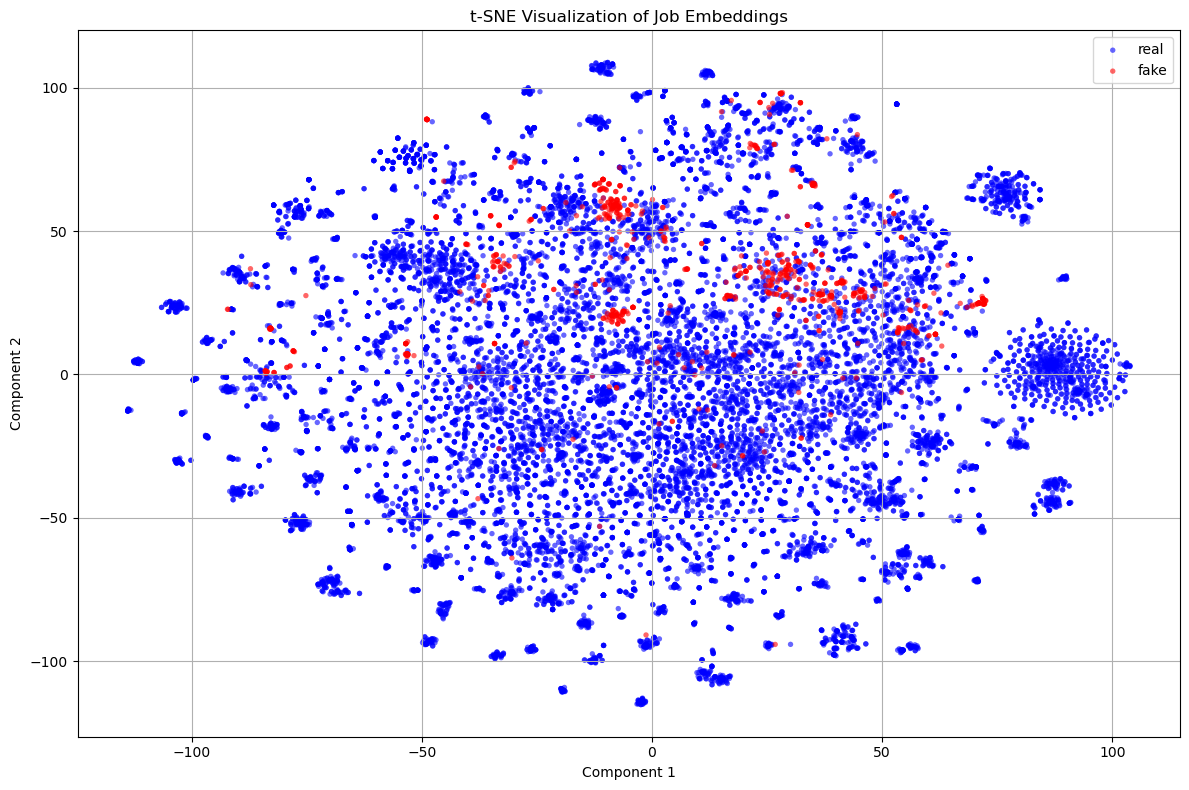

In [178]:
labels = [entry["Job Authenticity"] for entry in structured_corpus]
colors = {"real": "blue", "fake": "red"}

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(word_embeddings_transformer)

plt.figure(figsize=(12, 8))

# Plot real jobs first, then fake jobs on top
for label in ["real", "fake"]:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        tsne_embeddings[indices, 0],
        tsne_embeddings[indices, 1],
        c=colors[label],
        label=label,
        alpha=0.6,
        edgecolors='none',
        s=15)

plt.title("t-SNE Visualization of Job Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### PCA

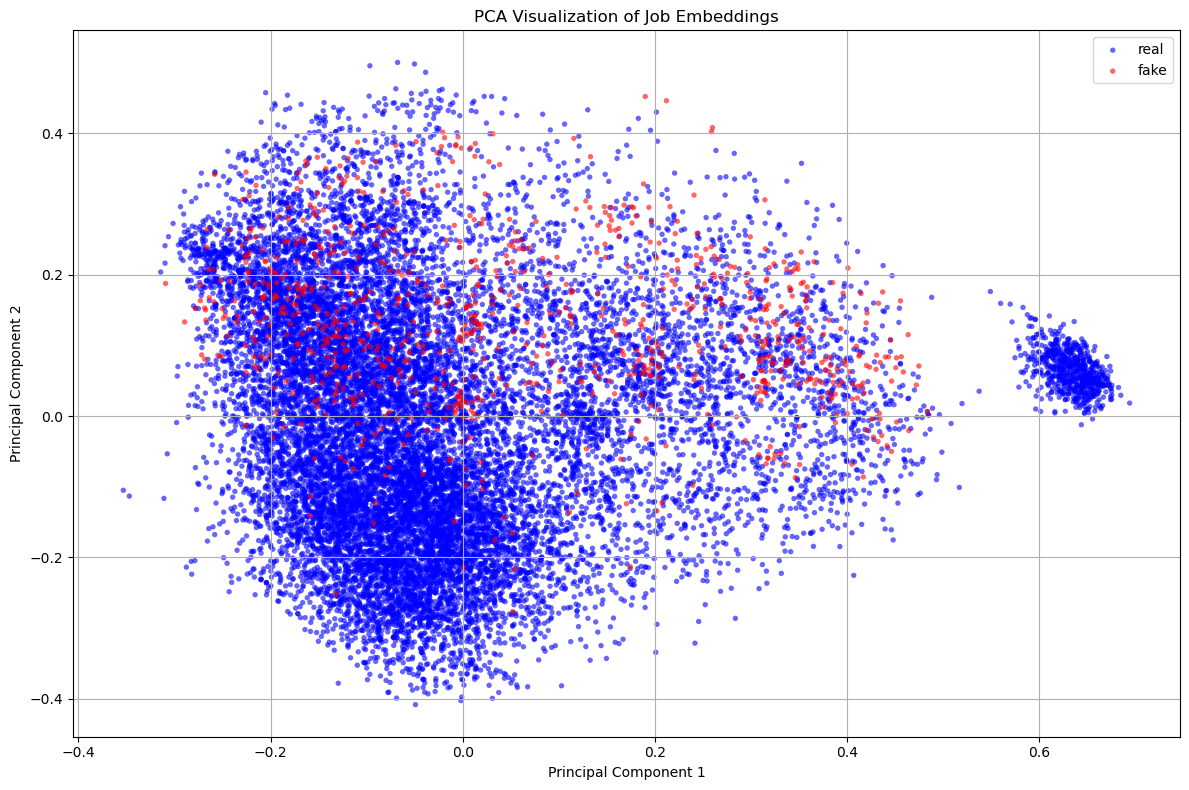

In [179]:
labels = [entry["Job Authenticity"] for entry in structured_corpus]
colors = {"real": "blue", "fake": "red"}\

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(word_embeddings_transformer)

plt.figure(figsize=(12, 8))

# Plot real jobs first, then fake jobs on top
for label in ["real", "fake"]:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        pca_embeddings[indices, 0],
        pca_embeddings[indices, 1],
        c=colors[label],
        label=label,
        alpha=0.6,
        edgecolors='none',
        s=15)

plt.title("PCA Visualization of Job Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()